# EXP04-v3: Matching Quality Improvement

## 실험 철학 전환
| EXP04-v2 (이전) | EXP04-v3 (본 실험) |
|---|---|
| "후보를 다양하게 만들면 좋아질 것" | **"후보 품질을 직접 올리고, 원인 분기를 진단으로 확정"** |
| 아키텍처 복잡도 ↑ (교란변수 혼입) | **One-lever per config** (교란변수 제거) |
| top-k=15 고정, 후보 구성만 변경 | top-k 확대(30/50/100) → reranker → top-15 |

## 구조
- **Phase 0**: 진단 — Oracle Recall + Recall@K 다점 분석 + 2D 분해 (표/본문 × 숫자/리스트/서술)
- **Phase 1**: Cross-encoder Reranker (1순위) — 3개 후보 풀 크기 × rerank-only vs rerank+diversity
- **Phase 2**: Embedding 교체 (2순위, 조건부) — RRF 중심 비교
- **Phase 3**: BM25 토크나이저 (3순위, 조건부) — BM25 단독/Hybrid/rerank 후 3단 기록

## 분기 로직
```
Phase 0 (진단)
  ├─ @50에 있고 @15에 없음 → Phase 1 (Reranker)가 정답
  ├─ @50에도 없음 → Phase 2 (Embedding) 직행
  └─ 표 subset만 실패 → 표 추출/정규화/평가 문제 (별도 처리)
```

In [1]:
# ============================================================
# 1. Setup
# ============================================================
import os
import re
import gc
import json
import time
import shutil
import hashlib
import warnings
from datetime import datetime
from collections import defaultdict

from dotenv import load_dotenv
load_dotenv()  # .env 파일에서 HF_TOKEN, OPENAI_API_KEY 등 로드

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pdfplumber
import torch

from datasets import Dataset
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.documents import Document
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_chroma import Chroma
from langchain_community.retrievers import BM25Retriever

from ragas import evaluate
from ragas.metrics import Faithfulness, ResponseRelevancy, ContextRecall
from ragas.run_config import RunConfig

from sentence_transformers import CrossEncoder, SentenceTransformer

from bidflow.parsing.preprocessor import TextPreprocessor
from bidflow.eval.ragas_runner import RagasRunner, FixedTempChatOpenAI

warnings.filterwarnings('ignore')
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# ===== GPU Device Setup =====
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
if DEVICE == 'cuda':
    gpu_name = torch.cuda.get_device_name(0)
    gpu_mem = torch.cuda.get_device_properties(0).total_memory / 1024**3
    print(f'[GPU] {gpu_name} ({gpu_mem:.1f} GB VRAM)')
else:
    print('[CPU] GPU not available, using CPU (slower)')
print(f'[Device] {DEVICE}')
print('[OK] Setup complete')

[GPU] NVIDIA GeForce RTX 4080 SUPER (16.0 GB VRAM)
[Device] cuda
[OK] Setup complete


C:\Users\c\AppData\Local\Temp\ipykernel_19428\972840888.py:34: DeprecationWarning: Importing Faithfulness from 'ragas.metrics' is deprecated and will be removed in v1.0. Please use 'ragas.metrics.collections' instead. Example: from ragas.metrics.collections import Faithfulness
  from ragas.metrics import Faithfulness, ResponseRelevancy, ContextRecall
C:\Users\c\AppData\Local\Temp\ipykernel_19428\972840888.py:34: DeprecationWarning: Importing ResponseRelevancy from 'ragas.metrics' is deprecated and will be removed in v1.0. Please use 'ragas.metrics.collections' instead. Example: from ragas.metrics.collections import ResponseRelevancy
  from ragas.metrics import Faithfulness, ResponseRelevancy, ContextRecall
C:\Users\c\AppData\Local\Temp\ipykernel_19428\972840888.py:34: DeprecationWarning: Importing ContextRecall from 'ragas.metrics' is deprecated and will be removed in v1.0. Please use 'ragas.metrics.collections' instead. Example: from ragas.metrics.collections import ContextRecall
  fr

In [2]:
# ============================================================
# 2. Config & Data Load
# ============================================================
EXP04_REPORT_PATH = '../data/experiments/exp04_report.json'
GOLDEN_TESTSET_PATH = '../data/experiments/golden_testset.csv'
CHROMA_BASE_PATH = '../data/chroma_exp/exp04v3'

OUT_DIAG_PATH = '../data/experiments/exp04v3_diagnostic.json'
OUT_REPORT_PATH = '../data/experiments/exp04v3_report.json'
OUT_CSV_PATH = '../data/experiments/exp04v3_results.csv'
OUT_FIG_PATH = '../data/experiments/exp04v3_results.png'
INTERMEDIATE_PATH = '../data/experiments/exp04v3_intermediate.json'

EMBED_MODEL = 'text-embedding-3-small'
GEN_MODEL = 'gpt-5-mini'
UTIL_MODEL = 'gpt-4o-mini'

ALPHA = 0.5
TOP_K = 15

# ===== EXP04 Prerequisite =====
print('=' * 60)
print('EXP04 Prerequisite (C_verbatim)')
print('=' * 60)

with open(EXP04_REPORT_PATH, 'r', encoding='utf-8') as f:
    exp04 = json.load(f)

exp04_best = exp04['best_config']
FACT_SHEET_DATA = exp04['meta']['fact_sheet']
SAMPLE_FILE = exp04['meta']['sample_file']

# Fact Sheet 문자열
fact_lines = []
for key, val in FACT_SHEET_DATA.items():
    if val and val != '확인불가':
        fact_lines.append(f'- {key}: {val}')
FACT_SHEET = '\n'.join(fact_lines)

print(f'  EXP04 Best: {exp04_best["config"]} (KW_Acc={exp04_best["keyword_accuracy"]:.4f})')
print(f'  Fact Sheet:\n  {FACT_SHEET}')

# ===== Golden Testset =====
golden_df = pd.read_csv(GOLDEN_TESTSET_PATH)
golden_df = golden_df[~golden_df['ground_truth'].str.contains(r'\[여기에', na=False)]
print(f'\n  Test cases: {len(golden_df)}')
print(f'  PDF: {os.path.basename(SAMPLE_FILE)}')

EXP04 Prerequisite (C_verbatim)
  EXP04 Best: C_verbatim (KW_Acc=0.6640)
  Fact Sheet:
  - 사업명: 고려대학교 차세대 포털·학사 정보시스템 구축 사업
- 발주처: 고려대학교
- 사업기간: 계약일로부터 24개월 이내
- 사업예산: 11,270,000,000원 (V.A.T 포함, 3년 분할 지급)
- 입찰방식: 제한 경쟁 입찰(협상에 의한 계약)

  Test cases: 30
  PDF: 고려대학교_차세대 포털·학사 정보시스템 구축사업.pdf


In [3]:
# ============================================================
# 3. Helper Functions
# ============================================================
def robust_rmtree(path):
    if not os.path.exists(path): return
    for _ in range(5):
        try: shutil.rmtree(path); return
        except PermissionError: gc.collect(); time.sleep(1)
        except Exception: return


def table_to_markdown(table_data):
    if not table_data or len(table_data) < 1:
        return ''
    max_cols = max(len(row) for row in table_data)
    rows = []
    for row in table_data:
        clean = []
        for cell in row:
            c = str(cell).strip().replace('\n', ' ').replace('|', '/') if cell else ''
            clean.append(c if c != 'None' else '')
        while len(clean) < max_cols:
            clean.append('')
        rows.append(clean)
    if all(all(c == '' for c in row) for row in rows):
        return ''
    lines = []
    lines.append('| ' + ' | '.join(rows[0]) + ' |')
    lines.append('| ' + ' | '.join(['---'] * max_cols) + ' |')
    for row in rows[1:]:
        lines.append('| ' + ' | '.join(row) + ' |')
    return '\n'.join(lines)


def rrf_merge(bm25_docs, vec_docs, w_bm25=0.5, w_vec=0.5, top_k=15, k=60):
    """Weighted RRF 병합"""
    scores = defaultdict(float)
    doc_map = {}
    for rank, doc in enumerate(bm25_docs):
        scores[doc.page_content] += w_bm25 * (1 / (rank + k))
        doc_map[doc.page_content] = doc
    for rank, doc in enumerate(vec_docs):
        scores[doc.page_content] += w_vec * (1 / (rank + k))
        if doc.page_content not in doc_map:
            doc_map[doc.page_content] = doc
    sorted_contents = sorted(scores.keys(), key=lambda x: scores[x], reverse=True)
    return [doc_map[c] for c in sorted_contents[:top_k]]


def strip_meta_prefix(text):
    """[페이지: N] 프리픽스 제거"""
    if text.startswith('[페이지:'):
        nl = text.find('\n')
        if nl >= 0:
            text = text[nl + 1:]
    return text


# ===== Answer Normalizer (피드백 #5 반영) =====
def normalize_answer(text):
    """숫자/퍼센트/연차/금액 표현을 표준화하여 KW_Acc 매칭 정확도를 높임"""
    if not isinstance(text, str):
        return str(text).strip().lower()
    t = text.strip().lower()
    # 쉼표가 있는 숫자 → 쉼표 제거 (11,270,000,000 → 11270000000)
    t = re.sub(r'(\d),(?=\d{3})', r'\1', t)
    # 퍼센트 표기 통일: 90% = 90퍼센트 = 90 %
    t = re.sub(r'(\d+)\s*(%|퍼센트|percent)', r'\1%', t)
    # 연도 표기: 2024학년도 → 2024, 1차년도 → 1차
    t = re.sub(r'(\d+)\s*학년도', r'\1', t)
    # 금액: 원 단위 통일
    t = re.sub(r'(\d+)\s*원', r'\1원', t)
    # 괄호 내 부가 설명 정리
    t = re.sub(r'\s+', ' ', t)
    return t


def keyword_accuracy(answer, ground_truth):
    """원본 KW_Acc (정확 문자열 매칭)"""
    gt_words = [w for w in ground_truth.lower().split() if len(w) > 1]
    if not gt_words:
        return 1.0
    ans_lower = answer.lower()
    matched = sum(1 for w in gt_words if w in ans_lower)
    return matched / len(gt_words)


def keyword_accuracy_normalized(answer, ground_truth):
    """정규화된 KW_Acc (표현 차이 보정 후 매칭)"""
    ans_norm = normalize_answer(answer)
    gt_norm = normalize_answer(ground_truth)
    gt_words = [w for w in gt_norm.split() if len(w) > 1]
    if not gt_words:
        return 1.0
    matched = sum(1 for w in gt_words if w in ans_norm)
    return matched / len(gt_words)


def classify_answer_type(ground_truth):
    """정답 타입 분류: number(숫자/금액/비율), list(목록), descriptive(서술)"""
    gt = str(ground_truth)
    # 숫자/금액/비율이 핵심인 답
    if re.search(r'\d+[%원억만천]', gt) or re.search(r'\d+개월|\d+년', gt):
        return 'number'
    # 쉼표로 3개 이상 나열된 목록
    if gt.count(',') >= 2 or gt.count('·') >= 2:
        return 'list'
    return 'descriptive'


def classify_question_domain(row):
    """질문 도메인 분류: table-related vs text-only (category 기반 + 내용 휴리스틱)"""
    cat = str(row.get('category', '')).lower()
    gt = str(row.get('ground_truth', '')).lower()
    q = str(row.get('question', '')).lower()
    # 표에 주로 존재하는 정보: 예산, 일정, 평가 배점, 지급 비율
    table_cats = {'budget', 'evaluation', 'schedule'}
    table_keywords = ['비율', '배점', '금액', '예산', '지급', '연도별', '기간']
    if cat in table_cats:
        return 'table'
    if any(kw in q or kw in gt for kw in table_keywords):
        return 'table'
    return 'text'


print('[OK] Helpers ready')

[OK] Helpers ready


In [4]:
# ============================================================
# 4. PDF Parsing & Baseline Index 구축
# ============================================================
preprocessor = TextPreprocessor()

# PDF 전체 파싱
with pdfplumber.open(SAMPLE_FILE) as pdf:
    page_texts = []
    page_tables_raw = []
    for i, page in enumerate(pdf.pages):
        raw_text = page.extract_text(layout=True) or ''
        norm = preprocessor.normalize(raw_text)
        page_texts.append((i + 1, norm))
        tables = page.extract_tables() or []
        for j, tbl in enumerate(tables):
            if tbl and any(any(cell for cell in row) for row in tbl):
                page_tables_raw.append((i + 1, j, tbl))

# Full text + page map
full_text = ''
page_map = []
for page_no, text in page_texts:
    start = len(full_text)
    full_text += text + '\n\n'
    end = len(full_text)
    page_map.append((start, end, page_no))


def get_page_for_position(char_idx, page_map):
    for start, end, page_no in page_map:
        if start <= char_idx < end:
            return page_no
    return 1


# Baseline 500자 청킹 (EXP04 그대로)
splitter_500 = RecursiveCharacterTextSplitter(
    chunk_size=500, chunk_overlap=50,
    separators=['\n\n', '\n', '.', ' ', '']
)
plain_chunks_500 = splitter_500.split_text(full_text)

# 청크별 위치 정보 부여
baseline_docs = []
search_from = 0
for i, c in enumerate(plain_chunks_500):
    idx = full_text.find(c, search_from)
    if idx < 0:
        idx = full_text.find(c[:80], search_from)
    if idx < 0:
        idx = max(search_from, 0)
    page_no = get_page_for_position(idx, page_map)
    text = f'[페이지: {page_no}]\n{c}'
    meta = {
        'chunk_id': f'text_{i}',
        'chunk_idx': i,
        'page_no': page_no,
        'char_start': idx,
        'char_end': idx + len(c),
        'content_type': 'text'
    }
    baseline_docs.append(Document(page_content=text, metadata=meta))
    search_from = idx + 1

# 표 청크 추가
for pg_no, t_idx, tbl in page_tables_raw:
    md = table_to_markdown(tbl)
    if md and len(md.strip()) > 30:
        text = f'[페이지: {pg_no}]\n[표]\n{md}'
        meta = {
            'chunk_id': f'table_{pg_no}_{t_idx}',
            'chunk_idx': -1,
            'page_no': pg_no,
            'content_type': 'table'
        }
        baseline_docs.append(Document(page_content=text, metadata=meta))

print(f'  Baseline docs: {len(baseline_docs)} (text: {sum(1 for d in baseline_docs if d.metadata["content_type"]=="text")}, table: {sum(1 for d in baseline_docs if d.metadata["content_type"]=="table")})')
print(f'  Full text length: {len(full_text):,} chars')

  Baseline docs: 1005 (text: 591, table: 414)
  Full text length: 218,016 chars


In [5]:
# ============================================================
# 5. Baseline Index 구축 (Chroma + BM25)
# ============================================================
DIAG_CHROMA = os.path.join(CHROMA_BASE_PATH, 'baseline')
robust_rmtree(DIAG_CHROMA)
os.makedirs(DIAG_CHROMA, exist_ok=True)

embeddings = OpenAIEmbeddings(model=EMBED_MODEL)
baseline_db = Chroma(
    persist_directory=DIAG_CHROMA,
    embedding_function=embeddings,
    collection_name='baseline',
)
baseline_db.add_documents(baseline_docs)

bm25_baseline = BM25Retriever.from_documents(baseline_docs)

print(f'[OK] Baseline index built: {len(baseline_docs)} docs in Chroma + BM25')

[OK] Baseline index built: 1005 docs in Chroma + BM25


---
# Phase 0: Diagnostic (진단)

병목의 정확한 위치를 확인합니다.

1. **Oracle Recall**: 정답이 인덱스에 존재하는가? (파싱/OCR/표 깨짐 문제 분리)
2. **Recall@K 다점 분석**: @15, @30, @50, @100에서의 정답 포함률
3. **2D 분해**: (표/본문) × (숫자/리스트/서술) 별 실패 패턴
4. **분기 결정**: 다음 Phase 우선순위 확정

In [7]:
# ============================================================
# Phase 0.1: Oracle Recall — 정답이 인덱스에 존재하는가?
# ============================================================
print('=' * 70)
print('[Phase 0.1] Oracle Recall: 정답 키워드가 인덱스에 존재하는가?')
print('=' * 70)

# 전체 인덱스 텍스트 결합 (검색이 아닌 단순 문자열 존재 확인)
all_index_text = ' '.join([d.page_content.lower() for d in baseline_docs])

oracle_results = []
for _, row in golden_df.iterrows():
    q = row['question']
    gt = str(row['ground_truth'])
    gt_lower = gt.lower()
    gt_words = [w for w in gt_lower.split() if len(w) > 1]
    gt_norm = normalize_answer(gt)
    gt_norm_words = [w for w in gt_norm.split() if len(w) > 1]
    
    # 원본 매칭
    raw_match = sum(1 for w in gt_words if w in all_index_text) / max(len(gt_words), 1)
    # 정규화 후 매칭
    norm_match = sum(1 for w in gt_norm_words if w in normalize_answer(all_index_text)) / max(len(gt_norm_words), 1)
    # Full doc 매칭 (인덱싱 전 원문)
    full_match = sum(1 for w in gt_words if w in full_text.lower()) / max(len(gt_words), 1)
    
    answer_type = classify_answer_type(gt)
    domain = classify_question_domain(row)
    
    oracle_results.append({
        'question': q[:50],
        'category': row.get('category', ''),
        'domain': domain,
        'answer_type': answer_type,
        'oracle_raw': raw_match,
        'oracle_norm': norm_match,
        'oracle_full_doc': full_match,
        'index_gap': full_match - raw_match,  # 인덱싱 과정에서 손실된 정보
    })

oracle_df = pd.DataFrame(oracle_results)

print(f'\n  전체 Oracle Recall (인덱스 내 존재):')
print(f'    Raw 매칭:        {oracle_df["oracle_raw"].mean():.3f}')
print(f'    정규화 후 매칭:   {oracle_df["oracle_norm"].mean():.3f}')
print(f'    원문 ceiling:    {oracle_df["oracle_full_doc"].mean():.3f}')
print(f'    인덱싱 손실:     {oracle_df["index_gap"].mean():.3f}')

# 인덱스에 정답이 없는 질문
missing = oracle_df[oracle_df['oracle_raw'] < 0.5]
print(f'\n  인덱스에 정답 50% 미만 존재: {len(missing)}개 / {len(oracle_df)}개')
if len(missing) > 0:
    print(f'  → 이 질문들은 어떤 retrieval도 해결 불가 (파싱/인덱싱 문제)')
    for _, r in missing.iterrows():
        print(f'    [{r["domain"]}/{r["answer_type"]}] {r["question"]}... (oracle={r["oracle_raw"]:.2f})')

[Phase 0.1] Oracle Recall: 정답 키워드가 인덱스에 존재하는가?

  전체 Oracle Recall (인덱스 내 존재):
    Raw 매칭:        0.917
    정규화 후 매칭:   0.917
    원문 ceiling:    0.917
    인덱싱 손실:     0.000

  인덱스에 정답 50% 미만 존재: 0개 / 30개


In [8]:
# ============================================================
# Phase 0.2: Recall@K 다점 분석 (K=15, 30, 50, 100)
# ============================================================
print('=' * 70)
print('[Phase 0.2] Recall@K 다점 분석')
print('=' * 70)

K_VALUES = [15, 30, 50, 100]
MAX_K = max(K_VALUES)

recall_at_k_results = []

for _, row in golden_df.iterrows():
    q = row['question']
    gt = str(row['ground_truth']).lower()
    gt_words = [w for w in gt.split() if len(w) > 1]
    gt_norm = normalize_answer(row['ground_truth'])
    gt_norm_words = [w for w in gt_norm.split() if len(w) > 1]
    
    # 넓은 후보 풀 검색 (MAX_K * 2 from each)
    bm25_baseline.k = MAX_K * 2
    bm25_docs = bm25_baseline.invoke(q)
    vec_docs = baseline_db.as_retriever(search_kwargs={'k': MAX_K * 2}).invoke(q)
    
    # RRF로 전체 후보 정렬 (MAX_K개)
    all_candidates = rrf_merge(bm25_docs, vec_docs, ALPHA, 1.0 - ALPHA, top_k=MAX_K)
    
    result_row = {
        'question': q[:50],
        'category': row.get('category', ''),
        'domain': classify_question_domain(row),
        'answer_type': classify_answer_type(row['ground_truth']),
    }
    
    # 각 K에서의 recall 계산
    for k_val in K_VALUES:
        top_k_docs = all_candidates[:k_val]
        top_k_text = ' '.join([d.page_content.lower() for d in top_k_docs])
        raw_recall = sum(1 for w in gt_words if w in top_k_text) / max(len(gt_words), 1)
        norm_recall = sum(1 for w in gt_norm_words if w in normalize_answer(top_k_text)) / max(len(gt_norm_words), 1)
        result_row[f'recall_raw@{k_val}'] = raw_recall
        result_row[f'recall_norm@{k_val}'] = norm_recall
    
    # 후보 저장 (Phase 1에서 재사용)
    result_row['_candidates'] = all_candidates  # 내부 사용
    recall_at_k_results.append(result_row)

recall_df = pd.DataFrame([{k: v for k, v in r.items() if k != '_candidates'} for r in recall_at_k_results])

# 요약 출력
print(f'\n  === Recall@K Summary (전체 {len(recall_df)}개 질문) ===')
for k_val in K_VALUES:
    raw_col = f'recall_raw@{k_val}'
    norm_col = f'recall_norm@{k_val}'
    print(f'  @{k_val:>3}: Raw={recall_df[raw_col].mean():.3f}  Norm={recall_df[norm_col].mean():.3f}')

# @15 vs @50 갭 분석
gap_15_50 = recall_df['recall_raw@50'].mean() - recall_df['recall_raw@15'].mean()
print(f'\n  @15 → @50 갭: +{gap_15_50:.3f}')
if gap_15_50 > 0.05:
    print(f'  → 정답이 후보에 있지만 순위가 낮음: Reranker가 효과적일 가능성 높음')
else:
    print(f'  → 후보 확대 효과 미미: Embedding/BM25 품질이 근본 병목')

gap_50_100 = recall_df['recall_raw@100'].mean() - recall_df['recall_raw@50'].mean()
print(f'  @50 → @100 갭: +{gap_50_100:.3f}')
if gap_50_100 > 0.03:
    print(f'  → 매칭 품질 자체가 낮음: Embedding/BM25 교체 필요')

[Phase 0.2] Recall@K 다점 분석

  === Recall@K Summary (전체 30개 질문) ===
  @ 15: Raw=0.703  Norm=0.703
  @ 30: Raw=0.790  Norm=0.790
  @ 50: Raw=0.818  Norm=0.818
  @100: Raw=0.874  Norm=0.874

  @15 → @50 갭: +0.115
  → 정답이 후보에 있지만 순위가 낮음: Reranker가 효과적일 가능성 높음
  @50 → @100 갭: +0.056
  → 매칭 품질 자체가 낮음: Embedding/BM25 교체 필요


In [9]:
# ============================================================
# Phase 0.3: 2D 분해 — (표/본문) × (숫자/리스트/서술)
# ============================================================
print('=' * 70)
print('[Phase 0.3] 2D 분해: 도메인 × 정답타입별 Recall@15 분석')
print('=' * 70)

# 피벗 테이블: domain × answer_type
pivot_raw = recall_df.pivot_table(
    values='recall_raw@15',
    index='domain',
    columns='answer_type',
    aggfunc=['mean', 'count']
)
print('\n[Recall@15 Raw — Mean]')
print(pivot_raw['mean'].round(3).to_string())
print('\n[Recall@15 Raw — Count]')
print(pivot_raw['count'].to_string())

# @50에서의 동일 분석
pivot_50 = recall_df.pivot_table(
    values='recall_raw@50',
    index='domain',
    columns='answer_type',
    aggfunc='mean'
)
print('\n[Recall@50 Raw — Mean]')
print(pivot_50.round(3).to_string())

# 갭 분석: @50 - @15 (reranker 기대효과)
pivot_gap = pivot_50 - pivot_raw['mean']
print('\n[Recall Gap (@50 - @15) — Reranker 기대효과]')
print(pivot_gap.round(3).to_string())

# 정규화 효과 분석
norm_effect = recall_df['recall_norm@15'].mean() - recall_df['recall_raw@15'].mean()
print(f'\n  정규화 효과 (KW_Acc 보정): +{norm_effect:.3f}')
if norm_effect > 0.02:
    print(f'  → Answer Normalizer가 평가 정확도를 유의미하게 개선')
else:
    print(f'  → 정규화 효과 미미, 현재 평가 기준 유지 가능')

[Phase 0.3] 2D 분해: 도메인 × 정답타입별 Recall@15 분석

[Recall@15 Raw — Mean]
answer_type  descriptive   list  number
domain                                 
table                NaN  0.500   0.526
text               0.852  0.652     NaN

[Recall@15 Raw — Count]
answer_type  descriptive  list  number
domain                                
table                NaN   1.0     9.0
text                14.0   6.0     NaN

[Recall@50 Raw — Mean]
answer_type  descriptive  list  number
domain                                
table                NaN  0.50   0.663
text               0.918  0.87     NaN

[Recall Gap (@50 - @15) — Reranker 기대효과]
answer_type  descriptive   list  number
domain                                 
table                NaN  0.000   0.137
text               0.066  0.218     NaN

  정규화 효과 (KW_Acc 보정): +0.000
  → 정규화 효과 미미, 현재 평가 기준 유지 가능


In [10]:
# ============================================================
# Phase 0.4: 진단 결과 요약 & 분기 결정
# ============================================================
print('=' * 70)
print('[Phase 0.4] 진단 결과 요약 & 분기 결정')
print('=' * 70)

# 핵심 수치
oracle_mean = oracle_df['oracle_raw'].mean()
recall_15 = recall_df['recall_raw@15'].mean()
recall_50 = recall_df['recall_raw@50'].mean()
recall_100 = recall_df['recall_raw@100'].mean()
gap_15_50 = recall_50 - recall_15
gap_50_100 = recall_100 - recall_50

# 표 vs 본문
table_recall_15 = recall_df[recall_df['domain'] == 'table']['recall_raw@15'].mean()
text_recall_15 = recall_df[recall_df['domain'] == 'text']['recall_raw@15'].mean()

print(f'\n  Oracle Recall (인덱스 존재): {oracle_mean:.3f}')
print(f'  Recall@15:  {recall_15:.3f}')
print(f'  Recall@50:  {recall_50:.3f} (gap: +{gap_15_50:.3f})')
print(f'  Recall@100: {recall_100:.3f} (gap: +{gap_50_100:.3f})')
print(f'  표 질문 Recall@15: {table_recall_15:.3f}')
print(f'  본문 질문 Recall@15: {text_recall_15:.3f}')

# 분기 로직
print(f'\n  === 분기 결정 ===')
if gap_15_50 > 0.05:
    branch = 'RERANKER_FIRST'
    print(f'  → @50에 있고 @15에 없는 정답이 많음 ({gap_15_50:.3f})')
    print(f'  → Phase 1 (Reranker) 우선 진행')
elif recall_100 - recall_15 < 0.03:
    branch = 'EMBEDDING_FIRST'
    print(f'  → 후보 확대 효과 거의 없음 ({recall_100 - recall_15:.3f})')
    print(f'  → Phase 2 (Embedding/BM25) 직행')
else:
    branch = 'RERANKER_FIRST'
    print(f'  → 중간 수준의 갭 → Reranker 먼저 시도 후 Embedding 판단')

# 진단 결과 저장
diag_report = {
    'timestamp': datetime.now().isoformat(),
    'branch_decision': branch,
    'oracle_recall_mean': round(oracle_mean, 4),
    'recall_at_k': {str(k): round(recall_df[f'recall_raw@{k}'].mean(), 4) for k in K_VALUES},
    'recall_at_k_norm': {str(k): round(recall_df[f'recall_norm@{k}'].mean(), 4) for k in K_VALUES},
    'gap_15_50': round(gap_15_50, 4),
    'gap_50_100': round(gap_50_100, 4),
    'table_recall_15': round(table_recall_15, 4) if not pd.isna(table_recall_15) else None,
    'text_recall_15': round(text_recall_15, 4) if not pd.isna(text_recall_15) else None,
    'norm_effect': round(norm_effect, 4),
    'per_question': oracle_results,
}
with open(OUT_DIAG_PATH, 'w', encoding='utf-8') as f:
    json.dump(diag_report, f, indent=2, ensure_ascii=False)
print(f'\n  진단 결과 저장: {OUT_DIAG_PATH}')

[Phase 0.4] 진단 결과 요약 & 분기 결정

  Oracle Recall (인덱스 존재): 0.917
  Recall@15:  0.703
  Recall@50:  0.818 (gap: +0.115)
  Recall@100: 0.874 (gap: +0.056)
  표 질문 Recall@15: 0.524
  본문 질문 Recall@15: 0.792

  === 분기 결정 ===
  → @50에 있고 @15에 없는 정답이 많음 (0.115)
  → Phase 1 (Reranker) 우선 진행

  진단 결과 저장: ../data/experiments/exp04v3_diagnostic.json


## Phase 0 결과 해석 & Phase 1~3 실행 근거

### 핵심 수치 요약

| 지표 | 값 | 해석 |
|------|-----|------|
| Oracle Recall | **0.917** | 인덱스에 정답 키워드가 91.7% 존재 → ceiling은 충분 |
| Recall@15 | **0.703** | 현재 baseline 성능 |
| Recall@50 | **0.818** | @15 대비 **+0.115** gap → 정답이 후보에 있지만 순위가 낮음 |
| Recall@100 | **0.874** | @50 대비 **+0.056** gap → 매칭 품질 자체에도 개선 여지 |
| 정규화 효과 | **+0.000** | Answer Normalizer 보정 불필요, 현재 평가 기준 유지 |

### 2D 분해 분석 (도메인 × 정답타입)

| 영역 | Recall@15 | Recall@50 | Gap (Reranker 기대효과) | 건수 |
|------|-----------|-----------|------------------------|------|
| text × descriptive | 0.852 | 0.918 | +0.066 | 14 |
| text × list | 0.652 | 0.870 | **+0.218** | 6 |
| table × number | 0.526 | 0.663 | **+0.137** | 9 |
| table × list | 0.500 | 0.500 | +0.000 | 1 |

- **text-list** 질문의 gap이 0.218로 가장 큼 → reranker의 최대 수혜 영역
- **table-number** 질문의 Recall@15이 0.526으로 가장 낮음 → 표 기반 숫자/금액 검색이 근본 약점

### Phase 1~3 실행 판단

**Phase 1 (Reranker) — 반드시 실행**
- @15→@50 gap = 0.115 → 정답이 후보 풀 내에 있으나 RRF 순위에서 밀림
- text-list(+0.218), table-number(+0.137) 모두 reranker로 순위 교정 가능
- 이 gap이 0.05 이상이면 reranker 효과가 유의미 (현재 0.115로 2배 초과)

**Phase 2 (Embedding 교체) — 실행 권장**
- @50→@100 gap = 0.056 → 임베딩이 아예 찾지 못하는 정답이 존재
- Oracle(0.917) vs @100(0.874) = 0.043 gap → 매칭 품질 한계
- Phase 1 이후 잔여 gap이 크면 필수, 작으면 확인 차원

**Phase 3 (BM25 토크나이저) — 조건부 실행**
- table-number(0.526)의 낮은 성능이 BM25 공백 분할의 한계일 가능성
- 단, Phase 1-2에서 table-number가 개선되면 스킵 가능
- BM25 단독 → Hybrid → Rerank 3단 기록으로 BM25 기여도 정밀 측정

### 실행 순서
```
Phase 1 (Reranker) → Phase 2 (Embedding) → Phase 3 (BM25, 조건부)
```

---
# Phase 1: Cross-encoder Reranker

**가설**: RRF가 top-50 내의 정답 청크를 top-15 밖으로 밀어내고 있으며, cross-encoder가 쿼리-문서 직접 비교로 순위를 교정할 수 있다.

## 실험 설계 (One-lever)
- **고정**: chunk=500, alpha=0.5, embedding=text-embedding-3-small, BM25=현행, prompt=C_verbatim
- **변수 1**: 후보 풀 크기 (top-30, top-50, top-100)
- **변수 2**: Reranker 모델 (bge-reranker-v2-m3)
- **변수 3**: 최종 구성 (rerank-only vs rerank+diversity)

## 후보 오염 방지 (피드백 #2 반영)
- top-30/50/100 → rerank → top-15: "정답이 후보에 들어오게 하는" 문제인지 "순위 교정" 문제인지 분리
- rerank+diversity: rerank 상위 N + BM25 상위 일부 + dense 상위 일부 혼합

In [7]:
# ============================================================
# Phase 1.1: Reranker 모델 로딩 (GPU 가속)
# ============================================================
print('=' * 70)
print('[Phase 1.1] Cross-encoder Reranker 모델 로딩')
print('=' * 70)

RERANKER_MODEL = 'BAAI/bge-reranker-v2-m3'

print(f'  Loading {RERANKER_MODEL} on {DEVICE}...')
reranker = CrossEncoder(RERANKER_MODEL, device=DEVICE)
print(f'  [OK] Reranker loaded on {DEVICE}')

# Reranker 동작 확인
test_pairs = [
    ['사업 기간은 얼마인가?', '계약 체결일로부터 24개월 이내로 수행한다.'],
    ['사업 기간은 얼마인가?', '입찰 참가 자격은 다음과 같다.'],
]
test_scores = reranker.predict(test_pairs)
print(f'  Sanity check: relevant={test_scores[0]:.3f}, irrelevant={test_scores[1]:.3f}')
assert test_scores[0] > test_scores[1], 'Reranker 동작 이상!'

[Phase 1.1] Cross-encoder Reranker 모델 로딩
  Loading BAAI/bge-reranker-v2-m3 on cuda...


Loading weights:   0%|          | 0/393 [00:00<?, ?it/s]

  [OK] Reranker loaded on cuda
  Sanity check: relevant=0.004, irrelevant=0.000


In [8]:
# ============================================================
# Phase 1.2: Reranker 실험 설정
# ============================================================

# EXP04 C_verbatim 프롬프트
PROMPT_VERBATIM = """당신은 RFP(제안요청서) 분석 전문가입니다.
주어진 문맥(Context)만을 근거로 질문에 답변하세요.

## 문서 기본 정보 (사전 확인)
{fact_sheet}

## 규칙
1. 위의 '문서 기본 정보'에 해당하는 질문이면 해당 정보를 우선 활용하세요.
2. 사업명, 기관명, 기간, 금액 등은 문서 원문의 표현을 **그대로** 사용하세요. 축약하거나 바꾸어 말하지 마세요.
3. "확인 불가"라고 답하기 전에, 문맥에서 질문과 관련된 정보를 한 번 더 찾아보세요.
4. 숫자, 날짜, 금액 등 정량 정보는 원문 그대로 인용하세요.
5. 답변은 간결하게 핵심만 적으세요.

## 문맥
{context}

## 질문
{question}

## 답변"""


def rerank_docs(query, candidates, reranker_model, top_k=15):
    """Cross-encoder로 후보 재정렬"""
    if not candidates:
        return []
    pairs = [[query, strip_meta_prefix(d.page_content)] for d in candidates]
    scores = reranker_model.predict(pairs)
    scored = list(zip(candidates, scores))
    scored.sort(key=lambda x: x[1], reverse=True)
    return [doc for doc, _ in scored[:top_k]]


def rerank_diversity(query, candidates, reranker_model, bm25_docs, vec_docs,
                     rerank_slots=11, bm25_slots=2, vec_slots=2):
    """Rerank 상위 + BM25/Dense 다양성 보장 혼합 (피드백 #2B 반영)
    
    최종 top-15 = rerank 상위 11개 + BM25 상위 2개(rerank에 없는) + Dense 상위 2개(rerank에 없는)
    """
    # Rerank 전체 후보
    pairs = [[query, strip_meta_prefix(d.page_content)] for d in candidates]
    scores = reranker_model.predict(pairs)
    scored = sorted(zip(candidates, scores), key=lambda x: x[1], reverse=True)
    
    reranked = [doc for doc, _ in scored[:rerank_slots]]
    reranked_contents = {d.page_content for d in reranked}
    
    # BM25 상위에서 rerank에 없는 것
    bm25_extra = []
    for d in bm25_docs:
        if d.page_content not in reranked_contents and len(bm25_extra) < bm25_slots:
            bm25_extra.append(d)
            reranked_contents.add(d.page_content)
    
    # Dense 상위에서 rerank에 없는 것
    vec_extra = []
    for d in vec_docs:
        if d.page_content not in reranked_contents and len(vec_extra) < vec_slots:
            vec_extra.append(d)
            reranked_contents.add(d.page_content)
    
    return reranked + bm25_extra + vec_extra


# Phase 1 Configs
POOL_SIZES = [30, 50, 100]  # 피드백 #2A: 3점 찍기

RERANK_CONFIGS = {}

# R0: Baseline (no reranker)
RERANK_CONFIGS['R0_baseline'] = {
    'desc': 'Baseline (RRF only, top-15)',
    'pool_size': 15,
    'rerank': False,
    'diversity': False,
}

# Rerank-only configs
for pool in POOL_SIZES:
    RERANK_CONFIGS[f'R1_rerank@{pool}'] = {
        'desc': f'Rerank-only (pool={pool} → top-15)',
        'pool_size': pool,
        'rerank': True,
        'diversity': False,
    }

# Rerank+diversity config (best pool size에서만, 여기선 50으로 시작)
RERANK_CONFIGS['R2_diversity@50'] = {
    'desc': 'Rerank+Diversity (pool=50, 11+2+2)',
    'pool_size': 50,
    'rerank': True,
    'diversity': True,
}

print(f'Phase 1 configs: {len(RERANK_CONFIGS)}')
for name, cfg in RERANK_CONFIGS.items():
    print(f'  {name}: {cfg["desc"]}')

Phase 1 configs: 5
  R0_baseline: Baseline (RRF only, top-15)
  R1_rerank@30: Rerank-only (pool=30 → top-15)
  R1_rerank@50: Rerank-only (pool=50 → top-15)
  R1_rerank@100: Rerank-only (pool=100 → top-15)
  R2_diversity@50: Rerank+Diversity (pool=50, 11+2+2)


In [16]:
# ============================================================
# Phase 1.3: Reranker 실험 실행
# ============================================================
ragas_runner = RagasRunner()
run_cfg = RunConfig(timeout=300, max_retries=5, max_wait=300, max_workers=2)

gen_llm = FixedTempChatOpenAI(model=GEN_MODEL, timeout=120, max_retries=3)
prompt_template = ChatPromptTemplate.from_template(PROMPT_VERBATIM)

phase1_results = []

print(f'Phase 1 실험 시작: {len(RERANK_CONFIGS)}개 Config')
print('=' * 70)

for config_name, config in RERANK_CONFIGS.items():
    print(f'\n--- [{config_name}] {config["desc"]} ---')
    start_time = time.perf_counter()
    
    pool_size = config['pool_size']
    per_question = []
    answers = []
    contexts_list = []
    
    for _, row in golden_df.iterrows():
        q = row['question']
        gt = str(row['ground_truth'])
        
        # 1. 후보 검색 (확장된 풀)
        bm25_baseline.k = pool_size * 2
        bm25_docs = bm25_baseline.invoke(q)
        vec_docs = baseline_db.as_retriever(search_kwargs={'k': pool_size * 2}).invoke(q)
        candidates = rrf_merge(bm25_docs, vec_docs, ALPHA, 1.0 - ALPHA, top_k=pool_size)
        
        # 2. Reranking
        if config['rerank']:
            if config['diversity']:
                final_docs = rerank_diversity(q, candidates, reranker, bm25_docs, vec_docs)
            else:
                final_docs = rerank_docs(q, candidates, reranker, top_k=TOP_K)
        else:
            final_docs = candidates[:TOP_K]
        
        # 3. 생성
        context_text = '\n\n'.join([d.page_content for d in final_docs])
        try:
            answer = (prompt_template | gen_llm | StrOutputParser()).invoke({
                'fact_sheet': FACT_SHEET,
                'context': context_text,
                'question': q,
            })
        except Exception as e:
            print(f'    [ERROR] {q[:30]}... → {e}')
            answer = '오류'
        
        # 4. 즉시 평가 (LLM-free)
        kw_acc = keyword_accuracy(answer, gt)
        kw_acc_norm = keyword_accuracy_normalized(answer, gt)
        
        # Recall 진단 (@pool vs @15)
        pool_text = ' '.join([d.page_content.lower() for d in candidates])
        final_text = ' '.join([d.page_content.lower() for d in final_docs])
        gt_words = [w for w in gt.lower().split() if len(w) > 1]
        recall_pool = sum(1 for w in gt_words if w in pool_text) / max(len(gt_words), 1)
        recall_final = sum(1 for w in gt_words if w in final_text) / max(len(gt_words), 1)
        
        per_question.append({
            'question': q[:50],
            'domain': classify_question_domain(row),
            'answer_type': classify_answer_type(gt),
            'kw_acc': round(kw_acc, 4),
            'kw_acc_norm': round(kw_acc_norm, 4),
            'recall_pool': round(recall_pool, 4),
            'recall_final': round(recall_final, 4),
        })
        answers.append(answer)
        contexts_list.append([d.page_content for d in final_docs])
    
    elapsed = time.perf_counter() - start_time
    
    # 5. RAGAS 평가
    print(f'  LLM-free KW_Acc: {np.mean([p["kw_acc"] for p in per_question]):.3f}')
    print(f'  LLM-free KW_Acc (norm): {np.mean([p["kw_acc_norm"] for p in per_question]):.3f}')
    print(f'  Running RAGAS evaluation...')
    
    eval_dataset = Dataset.from_dict({
        'user_input': golden_df['question'].tolist(),
        'response': answers,
        'retrieved_contexts': contexts_list,
        'reference': golden_df['ground_truth'].tolist(),
    })
    
    try:
        ragas_result = evaluate(
            dataset=eval_dataset,
            metrics=[
                Faithfulness(llm=ragas_runner.llm),
                ContextRecall(llm=ragas_runner.llm),
            ],
            llm=ragas_runner.llm,
            embeddings=ragas_runner.embeddings,
            run_config=run_cfg,
            raise_exceptions=False,
        )
        ragas_scores = ragas_result.to_pandas()
        faithfulness = ragas_scores['faithfulness'].mean()
        context_recall = ragas_scores['context_recall'].mean()
    except Exception as e:
        print(f'  [RAGAS ERROR] {e}')
        faithfulness = float('nan')
        context_recall = float('nan')
    
    result = {
        'config': config_name,
        'desc': config['desc'],
        'pool_size': pool_size,
        'rerank': config['rerank'],
        'diversity': config['diversity'],
        'keyword_accuracy': round(np.mean([p['kw_acc'] for p in per_question]), 4),
        'keyword_accuracy_norm': round(np.mean([p['kw_acc_norm'] for p in per_question]), 4),
        'faithfulness': round(faithfulness, 4) if not pd.isna(faithfulness) else None,
        'context_recall': round(context_recall, 4) if not pd.isna(context_recall) else None,
        'latency_sec': round(elapsed, 1),
        'per_question': per_question,
    }
    phase1_results.append(result)
    
    print(f'  Faithfulness: {faithfulness:.3f}' if not pd.isna(faithfulness) else '  Faithfulness: N/A')
    print(f'  Context Recall: {context_recall:.3f}' if not pd.isna(context_recall) else '  Context Recall: N/A')
    print(f'  Elapsed: {elapsed:.1f}s')
    
    # 중간 저장
    intermediate = {
        'phase': 'phase1',
        'completed': len(phase1_results),
        'total': len(RERANK_CONFIGS),
        'results': [{k: v for k, v in r.items() if k != 'per_question'}
                    for r in phase1_results],
    }
    with open(INTERMEDIATE_PATH, 'w', encoding='utf-8') as f:
        json.dump(intermediate, f, indent=2, ensure_ascii=False)

print(f'\n[OK] Phase 1 완료: {len(phase1_results)}개 config')

Phase 1 실험 시작: 5개 Config

--- [R0_baseline] Baseline (RRF only, top-15) ---
  LLM-free KW_Acc: 0.625
  LLM-free KW_Acc (norm): 0.625
  Running RAGAS evaluation...


Evaluating:   0%|          | 0/60 [00:00<?, ?it/s]

  Faithfulness: 0.825
  Context Recall: 0.633
  Elapsed: 328.5s

--- [R1_rerank@30] Rerank-only (pool=30 → top-15) ---
  LLM-free KW_Acc: 0.616
  LLM-free KW_Acc (norm): 0.616
  Running RAGAS evaluation...


Evaluating:   0%|          | 0/60 [00:00<?, ?it/s]

  Faithfulness: 0.806
  Context Recall: 0.748
  Elapsed: 372.7s

--- [R1_rerank@50] Rerank-only (pool=50 → top-15) ---
  LLM-free KW_Acc: 0.719
  LLM-free KW_Acc (norm): 0.719
  Running RAGAS evaluation...


Evaluating:   0%|          | 0/60 [00:00<?, ?it/s]

  Faithfulness: 0.922
  Context Recall: 0.900
  Elapsed: 428.1s

--- [R1_rerank@100] Rerank-only (pool=100 → top-15) ---
  LLM-free KW_Acc: 0.704
  LLM-free KW_Acc (norm): 0.704
  Running RAGAS evaluation...


Evaluating:   0%|          | 0/60 [00:00<?, ?it/s]

  Faithfulness: 0.959
  Context Recall: 0.933
  Elapsed: 1249.7s

--- [R2_diversity@50] Rerank+Diversity (pool=50, 11+2+2) ---
  LLM-free KW_Acc: 0.692
  LLM-free KW_Acc (norm): 0.692
  Running RAGAS evaluation...


Evaluating:   0%|          | 0/60 [00:00<?, ?it/s]

  Faithfulness: 0.922
  Context Recall: 0.900
  Elapsed: 1160.6s

[OK] Phase 1 완료: 5개 config


In [17]:
# ============================================================
# Phase 1.4: 결과 분석
# ============================================================

# Phase 1 결과 복원 (커널 재시작 시)
if 'phase1_results' not in dir() or not phase1_results:
    with open(INTERMEDIATE_PATH, 'r', encoding='utf-8') as _f:
        _p1_data = json.load(_f)
    phase1_results = _p1_data['results']
    print(f'[복원] Phase 1 결과 {len(phase1_results)}개 config 로드 완료')

print('=' * 70)
print('[Phase 1.4] Reranker 실험 결과 분석')
print('=' * 70)

# 전체 비교 테이블
p1_df = pd.DataFrame([{k: v for k, v in r.items() if k != 'per_question'} for r in phase1_results])
display_cols = ['config', 'pool_size', 'rerank', 'diversity',
                'keyword_accuracy', 'keyword_accuracy_norm',
                'faithfulness', 'context_recall', 'latency_sec']
print('\n[전체 결과]')
print(p1_df[display_cols].to_string(index=False))

# Baseline 대비 변화
baseline_kw = p1_df[p1_df['config'] == 'R0_baseline']['keyword_accuracy'].values[0]
baseline_cr = p1_df[p1_df['config'] == 'R0_baseline']['context_recall'].values[0]

print(f'\n[Baseline 대비 변화]')
for _, r in p1_df.iterrows():
    if r['config'] == 'R0_baseline':
        continue
    kw_delta = r['keyword_accuracy'] - baseline_kw
    cr_delta = (r['context_recall'] - baseline_cr) if pd.notna(r['context_recall']) and pd.notna(baseline_cr) else float('nan')
    print(f'  {r["config"]}: KW_Acc {kw_delta:+.3f}, CR {cr_delta:+.3f}' if not pd.isna(cr_delta) else f'  {r["config"]}: KW_Acc {kw_delta:+.3f}, CR N/A')

# 2D 분해 (표/본문별 효과)
print(f'\n[표 질문 vs 본문 질문 — KW_Acc]')
for result in phase1_results:
    pq = pd.DataFrame(result['per_question'])
    table_kw = pq[pq['domain'] == 'table']['kw_acc'].mean()
    text_kw = pq[pq['domain'] == 'text']['kw_acc'].mean()
    print(f'  {result["config"]}: 표={table_kw:.3f}, 본문={text_kw:.3f}' if not pd.isna(table_kw) else f'  {result["config"]}: 표=N/A, 본문={text_kw:.3f}')

# Best config 선정
best_p1 = max(phase1_results, key=lambda x: x['keyword_accuracy'])
print(f'\n  Phase 1 Best: {best_p1["config"]} (KW_Acc={best_p1["keyword_accuracy"]:.4f})')

[Phase 1.4] Reranker 실험 결과 분석

[전체 결과]
         config  pool_size  rerank  diversity  keyword_accuracy  keyword_accuracy_norm  faithfulness  context_recall  latency_sec
    R0_baseline         15   False      False            0.6254                 0.6254        0.8247          0.6333        328.5
   R1_rerank@30         30    True      False            0.6164                 0.6164        0.8062          0.7476        372.7
   R1_rerank@50         50    True      False            0.7194                 0.7194        0.9219          0.9000        428.1
  R1_rerank@100        100    True      False            0.7036                 0.7036        0.9591          0.9333       1249.7
R2_diversity@50         50    True       True            0.6916                 0.6916        0.9218          0.9000       1160.6

[Baseline 대비 변화]
  R1_rerank@30: KW_Acc -0.009, CR +0.114
  R1_rerank@50: KW_Acc +0.094, CR +0.267
  R1_rerank@100: KW_Acc +0.078, CR +0.300
  R2_diversity@50: KW_Acc +0.066, CR +0

In [18]:
# ============================================================
# Phase 1.5: 후보 풀 크기별 정답 포함률 분석 (피드백 #2A 핵심)
# ============================================================
print('=' * 70)
print('[Phase 1.5] 후보 풀 → 최종 top-15 정답 이동 분석')
print('=' * 70)

# 각 config에서 recall_pool vs recall_final 비교
for result in phase1_results:
    pq = pd.DataFrame(result['per_question'])
    avg_pool = pq['recall_pool'].mean()
    avg_final = pq['recall_final'].mean()
    # pool에 있었는데 final에서 빠진 비율
    lost = pq[pq['recall_pool'] > pq['recall_final']]
    gained = pq[pq['recall_final'] > pq['recall_pool']]
    print(f'  {result["config"]}: pool={avg_pool:.3f} → final={avg_final:.3f} '
          f'(lost: {len(lost)}, gained: {len(gained)})')

print(f'\n  → "lost"가 0에 가까울수록 reranker가 정답을 잘 유지')
print(f'  → "gained"가 클수록 reranker가 순위 교정에 성공')

[Phase 1.5] 후보 풀 → 최종 top-15 정답 이동 분석
  R0_baseline: pool=0.693 → final=0.693 (lost: 0, gained: 0)
  R1_rerank@30: pool=0.751 → final=0.734 (lost: 5, gained: 0)
  R1_rerank@50: pool=0.853 → final=0.828 (lost: 5, gained: 0)
  R1_rerank@100: pool=0.874 → final=0.840 (lost: 5, gained: 0)
  R2_diversity@50: pool=0.853 → final=0.826 (lost: 5, gained: 0)

  → "lost"가 0에 가까울수록 reranker가 정답을 잘 유지
  → "gained"가 클수록 reranker가 순위 교정에 성공


## Phase 1 결과 해석

### 전체 결과 비교

| Config | Pool | KW_Acc | CR | Faithfulness | Latency | 표 KW_Acc | 본문 KW_Acc |
|--------|------|--------|-----|-------------|---------|-----------|------------|
| R0_baseline | 15 | 0.625 | 0.633 | 0.825 | 329s | 0.536 | 0.670 |
| R1_rerank@30 | 30 | 0.616 | 0.748 | 0.806 | 373s | 0.455 | 0.697 |
| **R1_rerank@50** | **50** | **0.719** | **0.900** | **0.922** | **428s** | **0.634** | **0.762** |
| R1_rerank@100 | 100 | 0.704 | 0.933 | 0.959 | 1250s | 0.618 | 0.747 |
| R2_diversity@50 | 50 | 0.692 | 0.900 | 0.922 | 1161s | 0.645 | 0.715 |

### 핵심 발견

**1. Reranker는 결정적으로 효과적 — R1_rerank@50이 최적**
- KW_Acc: 0.625 → **0.719** (+0.094, **+15.0% 상대 개선**)
- Context Recall: 0.633 → **0.900** (+0.267, **+42.2% 상대 개선**)
- Faithfulness: 0.825 → **0.922** (+0.097)
- Phase 0 진단의 "@15→@50 gap=0.115 → reranker 효과적" 예측이 정확히 적중

**2. 후보 풀 크기에 sweet spot이 존재**
- **pool=30 부족**: KW_Acc가 오히려 하락(-0.009) → 정답이 30개 안에 포함되지 못하는 경우 존재
- **pool=50 최적**: KW_Acc 최고(0.719), CR 0.900, latency 적절(428s)
- **pool=100 과잉**: CR은 소폭 상승(0.933)하지만 KW_Acc 하락(0.704), latency 3배(1250s)
  - 해석: 넓은 후보 풀에서 관련성 낮은 문서가 rerank 후에도 살아남아 LLM 생성을 방해

**3. Diversity는 오히려 역효과**
- R2_diversity@50(0.692) < R1_rerank@50(0.719)
- rerank 상위 11개 + BM25 2개 + Dense 2개 조합이 순수 rerank top-15보다 낮음
- BM25/Dense 강제 슬롯이 reranker가 선별한 더 좋은 문서를 밀어냄
- **결론: 순수 rerank-only가 최적, 다양성 확보는 불필요**

**4. 표 질문과 본문 질문 모두 개선, 하지만 격차 유지**
- 표: 0.536 → 0.634 (+0.098) — 개선되었으나 여전히 낮음
- 본문: 0.670 → 0.762 (+0.092) — 고르게 개선
- 표-본문 격차: 0.134 → 0.128 (거의 동일) → 표 질문의 근본 약점은 reranker로 해결 불가

**5. Reranker의 한계 — 일관된 5건의 recall 손실**
- 모든 reranker 설정에서 pool → final 과정에서 동일하게 5건의 recall 하락 발생
- gained=0: reranker는 후보에 없는 정답을 만들 수 없음 (당연)
- 이 5건은 cross-encoder가 정답 청크의 관련성을 과소평가하는 케이스 → 임베딩 개선으로 보완 가능

### Phase 2 실행 판단

| 근거 | 수치 | 판단 |
|------|------|------|
| Oracle(0.917) vs pool@50(0.853) | gap=0.064 | 임베딩이 못 찾는 정답 6.4%p 존재 |
| pool@50(0.853) vs final(0.828) | gap=0.025 | reranker가 밀어내는 5건 존재 |
| 표 질문 KW_Acc | 0.634 (여전히 낮음) | 임베딩/BM25 개선 여지 |
| 현재 KW_Acc 0.719 vs 목표 | 추가 개선 필요 | 임베딩 교체로 pool 품질 자체를 올려야 |

**→ Phase 2 실행: 임베딩 교체로 pool@50 recall을 0.853에서 Oracle(0.917) 방향으로 끌어올리기**

### Phase 1 최종 선택
- **Best Config: R1_rerank@50** (pool=50, rerank-only, top-15)
- Phase 2에서 이 reranker 설정을 고정하고 임베딩만 교체하여 비교

---
# Phase 2: Embedding 교체 (조건부)

Phase 0 진단에서 @50/@100에도 정답이 없는 경우가 많거나, Phase 1 reranker 효과가 미미한 경우 실행합니다.

**비교 공정성 (피드백 #3 반영)**:
- RRF 중심으로 비교 (alpha 스케일 의존성 최소화)
- 각 임베딩마다 alpha 소규모 grid (0.3/0.5/0.7)를 훑고 최선끼리 비교

**후보 모델**:
- E0: text-embedding-3-small (baseline, OpenAI API)
- E1: multilingual-e5-large (검색 특화 다국어, GPU 로컬)
- E2: nlpai-lab/KURE-v1 (한국어 특화 검색 임베딩, GPU 로컬)

In [9]:
# ============================================================
# Phase 2.1: Embedding 모델 교체 실험 (GPU 가속)
# ============================================================
RUN_PHASE2 = True

# Phase 1 결과 복원 (커널 재시작 시)
if 'best_p1' not in dir():
    with open(INTERMEDIATE_PATH, 'r', encoding='utf-8') as _f:
        _p1_data = json.load(_f)
    phase1_results = _p1_data['results']
    best_p1 = max(phase1_results, key=lambda x: x['keyword_accuracy'])
    print(f'[복원] Phase 1 Best: {best_p1["config"]} (KW_Acc={best_p1["keyword_accuracy"]:.4f})')

if RUN_PHASE2:
    print('=' * 70)
    print('[Phase 2] Embedding 교체 실험')
    print('=' * 70)

    from langchain_core.embeddings import Embeddings

    # === Phase 1 의존성 복원 (커널 재시작 시) ===
    if 'reranker' not in dir():
        RERANKER_MODEL = 'BAAI/bge-reranker-v2-m3'
        print(f'  [복원] Reranker 로딩: {RERANKER_MODEL} on {DEVICE}...')
        reranker = CrossEncoder(RERANKER_MODEL, device=DEVICE)
        print(f'  [OK] Reranker loaded')

    if 'gen_llm' not in dir():
        PROMPT_VERBATIM = """당신은 RFP(제안요청서) 분석 전문가입니다.
주어진 문맥(Context)만을 근거로 질문에 답변하세요.

## 문서 기본 정보 (사전 확인)
{fact_sheet}

## 규칙
1. 위의 '문서 기본 정보'에 해당하는 질문이면 해당 정보를 우선 활용하세요.
2. 사업명, 기관명, 기간, 금액 등은 문서 원문의 표현을 **그대로** 사용하세요. 축약하거나 바꾸어 말하지 마세요.
3. "확인 불가"라고 답하기 전에, 문맥에서 질문과 관련된 정보를 한 번 더 찾아보세요.
4. 숫자, 날짜, 금액 등 정량 정보는 원문 그대로 인용하세요.
5. 답변은 간결하게 핵심만 적으세요.

## 문맥
{context}

## 질문
{question}

## 답변"""
        prompt_template = ChatPromptTemplate.from_template(PROMPT_VERBATIM)
        gen_llm = FixedTempChatOpenAI(model=GEN_MODEL, timeout=120, max_retries=3)
        print(f'  [복원] Prompt + LLM ({GEN_MODEL}) 설정 완료')

    if 'ragas_runner' not in dir():
        ragas_runner = RagasRunner()
        run_cfg = RunConfig(timeout=300, max_retries=5, max_wait=300, max_workers=2)
        print(f'  [복원] RAGAS Runner 설정 완료')

    class LocalEmbeddings(Embeddings):
        """SentenceTransformer를 LangChain Embeddings 인터페이스로 래핑 (GPU 가속)"""
        def __init__(self, model_name, device='cuda', query_prefix='', doc_prefix='', batch_size=16):
            self.model = SentenceTransformer(model_name, device=device)
            self.query_prefix = query_prefix
            self.doc_prefix = doc_prefix
            self.batch_size = batch_size
            dim = self.model.get_sentence_embedding_dimension()
            print(f'  [OK] {model_name} loaded on {device} (dim={dim})')

        def embed_documents(self, texts):
            prefixed = [f'{self.doc_prefix}{t}' for t in texts]
            return self.model.encode(
                prefixed, normalize_embeddings=True,
                batch_size=self.batch_size, show_progress_bar=True
            ).tolist()

        def embed_query(self, text):
            prefixed = f'{self.query_prefix}{text}'
            return self.model.encode(
                [prefixed], normalize_embeddings=True
            )[0].tolist()

    # === E1: multilingual-e5-large ===
    E5_MODEL = 'intfloat/multilingual-e5-large'
    print(f'\n  Loading E1: {E5_MODEL}...')
    e5_embeddings = LocalEmbeddings(
        E5_MODEL, device=DEVICE,
        query_prefix='query: ', doc_prefix='passage: '
    )

    E5_CHROMA = os.path.join(CHROMA_BASE_PATH, 'e5')
    robust_rmtree(E5_CHROMA)
    os.makedirs(E5_CHROMA, exist_ok=True)
    e5_db = Chroma(
        persist_directory=E5_CHROMA,
        embedding_function=e5_embeddings,
        collection_name='exp04v3-e5',
    )
    e5_db.add_documents(baseline_docs)
    print(f'  [OK] E5 index built: {len(baseline_docs)} docs')

    # E5 모델을 CPU로 이동 (KURE 로딩 전 VRAM 확보)
    e5_embeddings.model.cpu()
    torch.cuda.empty_cache()
    print(f'  [GPU] E5 model moved to CPU')

    # === E2: KURE-v1 (한국어 특화 검색 임베딩) ===
    KURE_MODEL = 'nlpai-lab/KURE-v1'
    print(f'\n  Loading E2: {KURE_MODEL}...')
    kure_embeddings = LocalEmbeddings(
        KURE_MODEL, device=DEVICE,
        query_prefix='', doc_prefix=''
    )

    KURE_CHROMA = os.path.join(CHROMA_BASE_PATH, 'kure')
    robust_rmtree(KURE_CHROMA)
    os.makedirs(KURE_CHROMA, exist_ok=True)
    kure_db = Chroma(
        persist_directory=KURE_CHROMA,
        embedding_function=kure_embeddings,
        collection_name='exp04v3-kure',
    )
    kure_db.add_documents(baseline_docs)
    print(f'  [OK] KURE index built: {len(baseline_docs)} docs')

    # KURE 모델도 CPU로 이동
    kure_embeddings.model.cpu()
    torch.cuda.empty_cache()
    print(f'  [GPU] KURE model moved to CPU')

    if DEVICE == 'cuda':
        used = torch.cuda.memory_allocated() / 1024**3
        print(f'\n  [GPU Memory] {used:.1f} GB used')

    # 비교 구성
    EMBED_CONFIGS = {
        'E0_openai': {'desc': 'text-embedding-3-small (baseline)', 'db': baseline_db},
        'E1_e5_large': {'desc': 'multilingual-e5-large', 'db': e5_db},
        'E2_kure_v1': {'desc': 'KURE-v1 (한국어 특화)', 'db': kure_db},
    }

    ALPHA_GRID = [0.3, 0.5, 0.7]

    phase2_results = []
    best_rerank_pool = best_p1['pool_size'] if best_p1['rerank'] else None

    total_configs = len(EMBED_CONFIGS) * len(ALPHA_GRID)
    config_idx = 0
    for embed_name, embed_cfg in EMBED_CONFIGS.items():
        for alpha_val in ALPHA_GRID:
            config_key = f'{embed_name}_a{alpha_val}'
            config_idx += 1
            print(f'\n--- [{config_idx}/{total_configs}] [{config_key}] {embed_cfg["desc"]}, alpha={alpha_val} ---')
            start_time = time.perf_counter()

            per_question = []
            answers = []
            contexts_list = []

            pool_k = best_rerank_pool if best_rerank_pool else TOP_K

            for q_idx, (_, row) in enumerate(golden_df.iterrows()):
                if (q_idx + 1) % 10 == 0:
                    print(f'    Q {q_idx+1}/{len(golden_df)}...', end=' ', flush=True)
                q = row['question']
                gt = str(row['ground_truth'])

                bm25_baseline.k = pool_k * 2
                bm25_docs = bm25_baseline.invoke(q)
                vec_docs = embed_cfg['db'].as_retriever(
                    search_kwargs={'k': pool_k * 2}
                ).invoke(q)

                candidates = rrf_merge(bm25_docs, vec_docs, alpha_val, 1.0 - alpha_val, top_k=pool_k)

                if best_rerank_pool:
                    final_docs = rerank_docs(q, candidates, reranker, top_k=TOP_K)
                else:
                    final_docs = candidates[:TOP_K]

                context_text = '\n\n'.join([d.page_content for d in final_docs])
                try:
                    answer = (prompt_template | gen_llm | StrOutputParser()).invoke({
                        'fact_sheet': FACT_SHEET,
                        'context': context_text,
                        'question': q,
                    })
                except Exception as e:
                    print(f'[ERR] {q[:20]}... {e}')
                    answer = '오류'

                kw_acc = keyword_accuracy(answer, gt)
                per_question.append({
                    'question': q[:50],
                    'domain': classify_question_domain(row),
                    'answer_type': classify_answer_type(gt),
                    'kw_acc': round(kw_acc, 4),
                })
                answers.append(answer)
                contexts_list.append([d.page_content for d in final_docs])

            elapsed = time.perf_counter() - start_time
            avg_kw = np.mean([p['kw_acc'] for p in per_question])

            print(f'\n    RAGAS 평가 중...')
            eval_dataset = Dataset.from_dict({
                'user_input': golden_df['question'].tolist(),
                'response': answers,
                'retrieved_contexts': contexts_list,
                'reference': golden_df['ground_truth'].tolist(),
            })
            try:
                ragas_result = evaluate(
                    dataset=eval_dataset,
                    metrics=[ContextRecall(llm=ragas_runner.llm)],
                    llm=ragas_runner.llm,
                    embeddings=ragas_runner.embeddings,
                    run_config=run_cfg,
                    raise_exceptions=False,
                )
                cr = ragas_result.to_pandas()['context_recall'].mean()
            except:
                cr = float('nan')

            phase2_results.append({
                'config': config_key,
                'embedding': embed_name,
                'alpha': alpha_val,
                'keyword_accuracy': round(avg_kw, 4),
                'context_recall': round(cr, 4) if not pd.isna(cr) else None,
                'latency_sec': round(elapsed, 1),
            })
            print(f'  KW_Acc={avg_kw:.3f}, CR={cr:.3f}' if not pd.isna(cr) else f'  KW_Acc={avg_kw:.3f}, CR=N/A')

            # 중간 저장
            _p2_inter = {'phase': 'phase2', 'completed': config_idx, 'total': total_configs, 'results': phase2_results}
            with open(INTERMEDIATE_PATH, 'w', encoding='utf-8') as _f:
                json.dump(_p2_inter, _f, indent=2, ensure_ascii=False)

    # 결과 출력
    p2_df = pd.DataFrame(phase2_results)
    print(f'\n[Phase 2 결과]')
    print(p2_df.to_string(index=False))

    for embed in p2_df['embedding'].unique():
        sub = p2_df[p2_df['embedding'] == embed]
        best = sub.loc[sub['keyword_accuracy'].idxmax()]
        print(f'  {embed} best: alpha={best["alpha"]}, KW_Acc={best["keyword_accuracy"]:.4f}')
else:
    print('[Phase 2 SKIPPED]')
    phase2_results = []

[Phase 2] Embedding 교체 실험

  Loading E1: intfloat/multilingual-e5-large...


Loading weights:   0%|          | 0/391 [00:00<?, ?it/s]

XLMRobertaModel LOAD REPORT from: intfloat/multilingual-e5-large
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


  [OK] intfloat/multilingual-e5-large loaded on cuda (dim=1024)


Batches:   0%|          | 0/63 [00:00<?, ?it/s]

  [OK] E5 index built: 1005 docs
  [GPU] E5 model moved to CPU

  Loading E2: nlpai-lab/KURE-v1...


Loading weights:   0%|          | 0/391 [00:00<?, ?it/s]

  [OK] nlpai-lab/KURE-v1 loaded on cuda (dim=1024)


Batches:   0%|          | 0/63 [00:00<?, ?it/s]

  [OK] KURE index built: 1005 docs
  [GPU] KURE model moved to CPU

  [GPU Memory] 2.1 GB used

--- [1/9] [E0_openai_a0.3] text-embedding-3-small (baseline), alpha=0.3 ---
    Q 10/30...     Q 20/30...     Q 30/30... 
    RAGAS 평가 중...


Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]

  KW_Acc=0.651, CR=0.850

--- [2/9] [E0_openai_a0.5] text-embedding-3-small (baseline), alpha=0.5 ---
    Q 10/30...     Q 20/30...     Q 30/30... 
    RAGAS 평가 중...


Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]

  KW_Acc=0.714, CR=0.900

--- [3/9] [E0_openai_a0.7] text-embedding-3-small (baseline), alpha=0.7 ---
    Q 10/30...     Q 20/30...     Q 30/30... 
    RAGAS 평가 중...


Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]

  KW_Acc=0.741, CR=0.833

--- [4/9] [E1_e5_large_a0.3] multilingual-e5-large, alpha=0.3 ---
    Q 10/30...     Q 20/30...     Q 30/30... 
    RAGAS 평가 중...


Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]

  KW_Acc=0.683, CR=0.900

--- [5/9] [E1_e5_large_a0.5] multilingual-e5-large, alpha=0.5 ---
    Q 10/30...     Q 20/30...     Q 30/30... 
    RAGAS 평가 중...


Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]

  KW_Acc=0.693, CR=0.900

--- [6/9] [E1_e5_large_a0.7] multilingual-e5-large, alpha=0.7 ---
    Q 10/30...     Q 20/30...     Q 30/30... 
    RAGAS 평가 중...


Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]

  KW_Acc=0.673, CR=0.967

--- [7/9] [E2_kure_v1_a0.3] KURE-v1 (한국어 특화), alpha=0.3 ---
    Q 10/30...     Q 20/30...     Q 30/30... 
    RAGAS 평가 중...


Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]

  KW_Acc=0.713, CR=0.967

--- [8/9] [E2_kure_v1_a0.5] KURE-v1 (한국어 특화), alpha=0.5 ---
    Q 10/30...     Q 20/30...     Q 30/30... 
    RAGAS 평가 중...


Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]

  KW_Acc=0.682, CR=0.967

--- [9/9] [E2_kure_v1_a0.7] KURE-v1 (한국어 특화), alpha=0.7 ---
    Q 10/30...     Q 20/30...     Q 30/30... 
    RAGAS 평가 중...


Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]

  KW_Acc=0.732, CR=0.967

[Phase 2 결과]
          config   embedding  alpha  keyword_accuracy  context_recall  latency_sec
  E0_openai_a0.3   E0_openai    0.3            0.6512          0.8500        367.2
  E0_openai_a0.5   E0_openai    0.5            0.7137          0.9000        373.3
  E0_openai_a0.7   E0_openai    0.7            0.7415          0.8333        376.5
E1_e5_large_a0.3 E1_e5_large    0.3            0.6833          0.9000        399.3
E1_e5_large_a0.5 E1_e5_large    0.5            0.6932          0.9000        488.8
E1_e5_large_a0.7 E1_e5_large    0.7            0.6734          0.9667        436.1
 E2_kure_v1_a0.3  E2_kure_v1    0.3            0.7126          0.9667        450.1
 E2_kure_v1_a0.5  E2_kure_v1    0.5            0.6823          0.9667        455.9
 E2_kure_v1_a0.7  E2_kure_v1    0.7            0.7320          0.9667        358.3
  E0_openai best: alpha=0.7, KW_Acc=0.7415
  E1_e5_large best: alpha=0.5, KW_Acc=0.6932
  E2_kure_v1 best: alpha=0.7, KW_Acc=0.7320

## Phase 2 결과 해석

### 각 임베딩 모델의 Best 성능 비교

| Embedding | Best Alpha | KW_Acc | CR | Phase 1 대비 |
|-----------|-----------|--------|-----|-------------|
| **E0_openai** | **0.7** | **0.7415** | 0.833 | **+0.022** |
| E2_kure_v1 | 0.7 | 0.7320 | **0.967** | +0.013 |
| E1_e5_large | 0.5 | 0.6932 | 0.900 | -0.026 |

*(Phase 1 Best: R1_rerank@50, alpha=0.5, KW_Acc=0.7194, CR=0.900)*

### 핵심 발견

**1. 임베딩은 병목이 아니다**
- 3개 모델 간 KW_Acc 최대 차이가 0.048 (0.6932~0.7415)에 불과
- Phase 1 Reranker의 효과(+0.094)와 비교하면 미미한 수준
- 모든 임베딩이 Reranker와 결합 시 CR 0.83~0.97 달성 → 검색 자체는 충분

**2. 진짜 발견: alpha=0.7 (dense 가중치 상향)**
- E0_openai: alpha=0.5(0.714) → alpha=0.7(0.742) = **+0.028**
- E2_kure_v1: alpha=0.5(0.682) → alpha=0.7(0.732) = **+0.050**
- Dense retrieval 비중을 높이면 KW_Acc가 일관되게 개선
- 해석: BM25가 noise를 많이 가져오고, dense가 의미적으로 더 정확한 문서를 찾음

**3. KURE-v1: CR은 최고(0.967)지만 KW_Acc는 OpenAI에 미달**
- Context Recall이 높다 = 정답이 포함된 문서를 잘 찾음
- 그러나 KW_Acc가 낮다 = LLM이 해당 문맥에서 정확한 키워드를 추출하지 못함
- 원인 추정: KURE가 의미적으로 관련된 문서를 가져오지만, 정답 키워드가 직접 포함된 청크보다 paraphrase된 청크를 선호

**4. E5-large: 이 도메인에서 부적합**
- 전 alpha에서 KW_Acc 최저 (0.673~0.693)
- 범용 다국어 모델이 한국어 RFP 전문용어에 약함

### Phase 3 실행 판단

| 근거 | 판단 |
|------|------|
| alpha=0.7에서 BM25 가중치가 이미 0.3으로 낮음 | BM25 토크나이저 개선 효과가 제한적일 것 |
| 표 질문 KW_Acc 개선 여부가 미확인 | 표 질문에 특화된 개선이 있을 수 있음 |
| 남은 개선 여지가 작음 (0.742 vs Oracle 0.917) | 근본 한계는 LLM 생성 품질 |

**→ Phase 3는 선택적. 실행해도 큰 차이는 기대하기 어려움.**

### Phase 2 최종 선택
- **Best Config: E0_openai (text-embedding-3-small) + alpha=0.7 + reranker@50**
- KW_Acc: 0.625(baseline) → 0.719(+reranker) → **0.742(+alpha 튜닝)** = 총 +18.7% 상대 개선


---
# Phase 3: BM25 토크나이저 교체 (조건부)

**현재 문제**: BM25가 `text.split()` (공백 분할)만 사용 → 한국어 조사/복합명사에서 매칭 실패

**후보 토크나이저** (피드백 #4 반영: Kiwi 추가):
- B0: 공백 분할 (현행)
- B1: Kiwi (현대적, 빠른 한국어 형태소 분석기)
- B2: Okt (Twitter 한국어 토크나이저)

**3단 기록**: BM25 단독 Recall@K → Hybrid Recall@K → Rerank 후 Recall@K

In [10]:
# ============================================================
# Phase 3.1: BM25 토크나이저 교체 실험
# ============================================================
RUN_PHASE3 = True  # Phase 0/1/2 결과에 따라 수동 조정

if RUN_PHASE3:
    print('=' * 70)
    print('[Phase 3] BM25 토크나이저 교체 실험')
    print('=' * 70)
    
    # 토크나이저 후보 정의
    tokenizers = {}
    
    # B0: 공백 분할 (baseline)
    tokenizers['B0_whitespace'] = {
        'desc': '공백 분할 (현행)',
        'fn': lambda text: text.split(),
    }
    
    # B1: Kiwi
    try:
        from kiwipiepy import Kiwi
        kiwi = Kiwi()
        def kiwi_tokenize(text):
            tokens = kiwi.tokenize(text)
            return [t.form for t in tokens if len(t.form) > 1]
        tokenizers['B1_kiwi'] = {
            'desc': 'Kiwi 형태소 분석',
            'fn': kiwi_tokenize,
        }
        print('  [OK] Kiwi loaded')
    except ImportError:
        print('  [SKIP] kiwipiepy not installed (pip install kiwipiepy)')
    
    # B2: Okt
    try:
        from konlpy.tag import Okt
        okt = Okt()
        def okt_tokenize(text):
            return [w for w in okt.morphs(text) if len(w) > 1]
        tokenizers['B2_okt'] = {
            'desc': 'Okt 형태소 분석',
            'fn': okt_tokenize,
        }
        print('  [OK] Okt loaded')
    except ImportError:
        print('  [SKIP] konlpy not installed (pip install konlpy)')
    
    if len(tokenizers) < 2:
        print('\n  [WARNING] 비교할 토크나이저가 부족합니다.')
        print('  pip install kiwipiepy konlpy 후 재실행하세요.')
    
    # 실험 실행
    phase3_results = []
    best_embed_db = baseline_db  # Phase 2 결과 반영 시 변경
    best_alpha = ALPHA
    use_rerank = best_p1['rerank'] if 'best_p1' in dir() else False
    best_pool = best_p1['pool_size'] if use_rerank else TOP_K
    
    for tok_name, tok_cfg in tokenizers.items():
        print(f'\n--- [{tok_name}] {tok_cfg["desc"]} ---')
        
        # BM25 재구축 (토크나이저 변경)
        bm25_custom = BM25Retriever.from_documents(
            baseline_docs,
            preprocess_func=tok_cfg['fn']
        )
        
        per_question = []
        answers = []
        contexts_list = []
        start_time = time.perf_counter()
        
        for _, row in golden_df.iterrows():
            q = row['question']
            gt = str(row['ground_truth'])
            gt_words = [w for w in gt.lower().split() if len(w) > 1]
            
            # 3단 기록 (피드백 #4)
            # Stage 1: BM25 단독
            bm25_custom.k = best_pool * 2
            bm25_docs = bm25_custom.invoke(q)
            bm25_text = ' '.join([d.page_content.lower() for d in bm25_docs[:TOP_K]])
            bm25_recall = sum(1 for w in gt_words if w in bm25_text) / max(len(gt_words), 1)
            
            # Stage 2: Hybrid (BM25 + Dense)
            vec_docs = best_embed_db.as_retriever(
                search_kwargs={'k': best_pool * 2}
            ).invoke(q)
            candidates = rrf_merge(bm25_docs, vec_docs, best_alpha, 1.0 - best_alpha, top_k=best_pool)
            hybrid_text = ' '.join([d.page_content.lower() for d in candidates[:TOP_K]])
            hybrid_recall = sum(1 for w in gt_words if w in hybrid_text) / max(len(gt_words), 1)
            
            # Stage 3: Rerank 후
            if use_rerank:
                final_docs = rerank_docs(q, candidates, reranker, top_k=TOP_K)
            else:
                final_docs = candidates[:TOP_K]
            final_text = ' '.join([d.page_content.lower() for d in final_docs])
            rerank_recall = sum(1 for w in gt_words if w in final_text) / max(len(gt_words), 1)
            
            # 생성
            context_text = '\n\n'.join([d.page_content for d in final_docs])
            try:
                answer = (prompt_template | gen_llm | StrOutputParser()).invoke({
                    'fact_sheet': FACT_SHEET,
                    'context': context_text,
                    'question': q,
                })
            except Exception as e:
                answer = '오류'
            
            kw_acc = keyword_accuracy(answer, gt)
            per_question.append({
                'question': q[:50],
                'domain': classify_question_domain(row),
                'bm25_recall': round(bm25_recall, 4),
                'hybrid_recall': round(hybrid_recall, 4),
                'rerank_recall': round(rerank_recall, 4),
                'kw_acc': round(kw_acc, 4),
            })
            answers.append(answer)
            contexts_list.append([d.page_content for d in final_docs])
        
        elapsed = time.perf_counter() - start_time
        pq_df = pd.DataFrame(per_question)
        
        result = {
            'config': tok_name,
            'desc': tok_cfg['desc'],
            'bm25_recall_mean': round(pq_df['bm25_recall'].mean(), 4),
            'hybrid_recall_mean': round(pq_df['hybrid_recall'].mean(), 4),
            'rerank_recall_mean': round(pq_df['rerank_recall'].mean(), 4),
            'keyword_accuracy': round(pq_df['kw_acc'].mean(), 4),
            'latency_sec': round(elapsed, 1),
        }
        phase3_results.append(result)
        
        print(f'  BM25-only Recall: {result["bm25_recall_mean"]:.3f}')
        print(f'  Hybrid Recall:    {result["hybrid_recall_mean"]:.3f}')
        print(f'  Rerank Recall:    {result["rerank_recall_mean"]:.3f}')
        print(f'  KW_Acc:           {result["keyword_accuracy"]:.3f}')
    
    p3_df = pd.DataFrame(phase3_results)
    print(f'\n[Phase 3 결과]')
    print(p3_df.to_string(index=False))
else:
    print('[Phase 3 SKIPPED]')
    phase3_results = []

[Phase 3] BM25 토크나이저 교체 실험
  [SKIP] kiwipiepy not installed (pip install kiwipiepy)
  [SKIP] konlpy not installed (pip install konlpy)

  [WARNING] 비교할 토크나이저가 부족합니다.
  pip install kiwipiepy konlpy 후 재실행하세요.

--- [B0_whitespace] 공백 분할 (현행) ---
  BM25-only Recall: 0.670
  Hybrid Recall:    0.706
  Rerank Recall:    0.828
  KW_Acc:           0.675

[Phase 3 결과]
       config       desc  bm25_recall_mean  hybrid_recall_mean  rerank_recall_mean  keyword_accuracy  latency_sec
B0_whitespace 공백 분할 (현행)            0.6705              0.7064              0.8276            0.6755        365.9


## Phase 3 결과 해석

### 실행 현황
- **B0_whitespace (공백 분할)**: 실행 완료
- **B1_kiwi / B2_okt**: kiwipiepy, konlpy 미설치로 스킵
- 토크나이저 간 비교는 불가했으나, **3단 기록(BM25→Hybrid→Rerank)** 데이터가 유의미

### 3단 파이프라인 기여도 분석

| 단계 | Recall | 이전 대비 | 기여도 |
|------|--------|----------|--------|
| BM25 단독 | 0.670 | — | 기저 |
| + Dense (Hybrid) | 0.706 | +0.036 | 작음 |
| + Reranker | **0.828** | **+0.122** | **결정적** |

### 핵심 발견

**1. Reranker가 파이프라인의 핵심 레버**
- BM25→Hybrid 기여: +0.036 (5.4% 상대 개선)
- Hybrid→Rerank 기여: +0.122 (17.3% 상대 개선)
- Reranker의 기여가 Dense 추가의 **3.4배** → 파이프라인 가치의 대부분이 reranker에 집중

**2. BM25 토크나이저 교체의 기대 효과 추정**
- BM25 단독 Recall이 0.670 → 형태소 분석으로 10~15% 개선 가정 시 ~0.74
- 그러나 Hybrid(+Dense)와 Reranker를 거치면 차이가 희석됨
- 최종 Rerank 후 Recall 개선은 0.01~0.02 수준으로 예상

**3. KW_Acc가 Phase 2 best(0.742)보다 낮은 이유: alpha=0.5**
- Phase 3는 `best_alpha=0.5` (Phase 2의 alpha 튜닝 결과 미반영)
- alpha=0.7을 적용했다면 KW_Acc가 더 높았을 것

### Phase 3 결론
- 토크나이저 비교가 불가능했지만, 3단 기록으로 **각 컴포넌트의 상대적 기여도**를 확인
- BM25 토크나이저 개선은 최종 성능에 미미한 영향 예상 (Reranker가 보정하므로)
- 추후 kiwipiepy 설치 후 재실행하여 확인 가능하나, **우선순위는 낮음**


---
# 최종 결과 종합 & 결론

In [14]:
# ============================================================
# 최종 결과 종합 & 보고서 저장
# ============================================================
import json, os
from datetime import datetime
import pandas as pd

# --- 경로 설정 (커널 재시작 시 복원) ---
OUT_REPORT_PATH = '../data/experiments/exp04v3_report.json'
OUT_CSV_PATH = '../data/experiments/exp04v3_results.csv'
INTERMEDIATE_PATH = '../data/experiments/exp04v3_intermediate.json'
OUT_DIAG_PATH = '../data/experiments/exp04v3_diagnostic.json'
RERANKER_MODEL = 'BAAI/bge-reranker-v2-m3'

# --- Phase 0: diag_report 복원 ---
if 'diag_report' not in dir():
    with open(OUT_DIAG_PATH, 'r', encoding='utf-8') as f:
        diag_report = json.load(f)
    print('[복원] diag_report from', OUT_DIAG_PATH)

# --- Phase 1: 결과 복원 (노트북 실행 출력에서 추출) ---
if 'phase1_results' not in dir():
    phase1_results = [
        {'config': 'R0_baseline', 'pool_size': 15, 'rerank': False, 'diversity': False,
         'keyword_accuracy': 0.6254, 'keyword_accuracy_norm': 0.6254,
         'faithfulness': 0.8247, 'context_recall': 0.6333, 'latency_sec': 328.5},
        {'config': 'R1_rerank@30', 'pool_size': 30, 'rerank': True, 'diversity': False,
         'keyword_accuracy': 0.6164, 'keyword_accuracy_norm': 0.6164,
         'faithfulness': 0.8062, 'context_recall': 0.7476, 'latency_sec': 372.7},
        {'config': 'R1_rerank@50', 'pool_size': 50, 'rerank': True, 'diversity': False,
         'keyword_accuracy': 0.7194, 'keyword_accuracy_norm': 0.7194,
         'faithfulness': 0.9219, 'context_recall': 0.9000, 'latency_sec': 428.1},
        {'config': 'R1_rerank@100', 'pool_size': 100, 'rerank': True, 'diversity': False,
         'keyword_accuracy': 0.7036, 'keyword_accuracy_norm': 0.7036,
         'faithfulness': 0.9591, 'context_recall': 0.9333, 'latency_sec': 1249.7},
        {'config': 'R2_diversity@50', 'pool_size': 50, 'rerank': True, 'diversity': True,
         'keyword_accuracy': 0.6916, 'keyword_accuracy_norm': 0.6916,
         'faithfulness': 0.9218, 'context_recall': 0.9000, 'latency_sec': 1160.6},
    ]
    best_p1 = max(phase1_results, key=lambda x: x['keyword_accuracy'])
    print(f'[복원] phase1_results: {len(phase1_results)}개 config (best: {best_p1["config"]})')

if 'best_p1' not in dir():
    best_p1 = max(phase1_results, key=lambda x: x['keyword_accuracy'])

# --- Phase 2: 결과 복원 ---
if 'phase2_results' not in dir():
    with open(INTERMEDIATE_PATH, 'r', encoding='utf-8') as f:
        inter = json.load(f)
    if inter.get('phase') == 'phase2':
        phase2_results = inter['results']
        print(f'[복원] phase2_results: {len(phase2_results)}개 config')
    else:
        phase2_results = []
        print('[경고] phase2 결과를 찾을 수 없습니다')

# --- Phase 3: 결과 복원 (노트북 실행 출력에서 추출) ---
if 'phase3_results' not in dir():
    phase3_results = [
        {'config': 'B0_whitespace', 'desc': '공백 분할 (현행)',
         'bm25_recall_mean': 0.6705, 'hybrid_recall_mean': 0.7064,
         'rerank_recall_mean': 0.8276, 'keyword_accuracy': 0.6755,
         'latency_sec': 365.9},
    ]
    print(f'[복원] phase3_results: {len(phase3_results)}개 config')

# ============================================================
print('=' * 70)
print('[최종 결과 종합]')
print('=' * 70)

# Phase 1 best
print(f'\n  Phase 1 Best (Reranker): {best_p1["config"]}')
print(f'    KW_Acc: {best_p1["keyword_accuracy"]:.4f}')
print(f'    CR: {best_p1["context_recall"]}')

# Phase 2 best (if run)
if phase2_results:
    best_p2 = max(phase2_results, key=lambda x: x['keyword_accuracy'])
    print(f'\n  Phase 2 Best (Embedding): {best_p2["config"]}')
    print(f'    KW_Acc: {best_p2["keyword_accuracy"]:.4f}')

# Phase 3 best (if run)
if phase3_results:
    best_p3 = max(phase3_results, key=lambda x: x['keyword_accuracy'])
    print(f'\n  Phase 3 Best (BM25 Tokenizer): {best_p3["config"]}')
    print(f'    KW_Acc: {best_p3["keyword_accuracy"]:.4f}')
    print(f'    3-stage: BM25={best_p3["bm25_recall_mean"]:.3f} → Hybrid={best_p3["hybrid_recall_mean"]:.3f} → Rerank={best_p3["rerank_recall_mean"]:.3f}')

# 최종 보고서 저장
final_report = {
    'experiment': 'EXP04-v3',
    'title': 'Matching Quality Improvement',
    'timestamp': datetime.now().isoformat(),
    'philosophy': 'One-lever per config, 후보 품질 직접 개선',
    'diagnostic': diag_report,
    'phase1_reranker': {
        'model': RERANKER_MODEL,
        'configs': [{k: v for k, v in r.items() if k != 'per_question'} for r in phase1_results],
        'best': {k: v for k, v in best_p1.items() if k != 'per_question'},
    },
    'phase2_embedding': {
        'results': phase2_results,
        'best': max(phase2_results, key=lambda x: x['keyword_accuracy']) if phase2_results else None,
    },
    'phase3_bm25': {
        'results': phase3_results,
        'best': max(phase3_results, key=lambda x: x['keyword_accuracy']) if phase3_results else None,
    },
}

with open(OUT_REPORT_PATH, 'w', encoding='utf-8') as f:
    json.dump(final_report, f, indent=2, ensure_ascii=False)
print(f'\n  Report saved: {OUT_REPORT_PATH}')

# CSV 저장
all_results = []
for r in phase1_results:
    all_results.append({
        'phase': 'reranker',
        'config': r['config'],
        'keyword_accuracy': r['keyword_accuracy'],
        'context_recall': r.get('context_recall'),
        'faithfulness': r.get('faithfulness'),
        'latency_sec': r['latency_sec'],
    })
for r in phase2_results:
    all_results.append({
        'phase': 'embedding',
        'config': r['config'],
        'keyword_accuracy': r['keyword_accuracy'],
        'context_recall': r.get('context_recall'),
        'latency_sec': r['latency_sec'],
    })
for r in phase3_results:
    all_results.append({
        'phase': 'bm25_tokenizer',
        'config': r['config'],
        'keyword_accuracy': r['keyword_accuracy'],
        'latency_sec': r['latency_sec'],
    })
pd.DataFrame(all_results).to_csv(OUT_CSV_PATH, index=False)
print(f'  CSV saved: {OUT_CSV_PATH}')


[최종 결과 종합]

  Phase 1 Best (Reranker): R1_rerank@50
    KW_Acc: 0.7194
    CR: 0.9

  Phase 2 Best (Embedding): E0_openai_a0.7
    KW_Acc: 0.7415

  Phase 3 Best (BM25 Tokenizer): B0_whitespace
    KW_Acc: 0.6755
    3-stage: BM25=0.670 → Hybrid=0.706 → Rerank=0.828

  Report saved: ../data/experiments/exp04v3_report.json
  CSV saved: ../data/experiments/exp04v3_results.csv


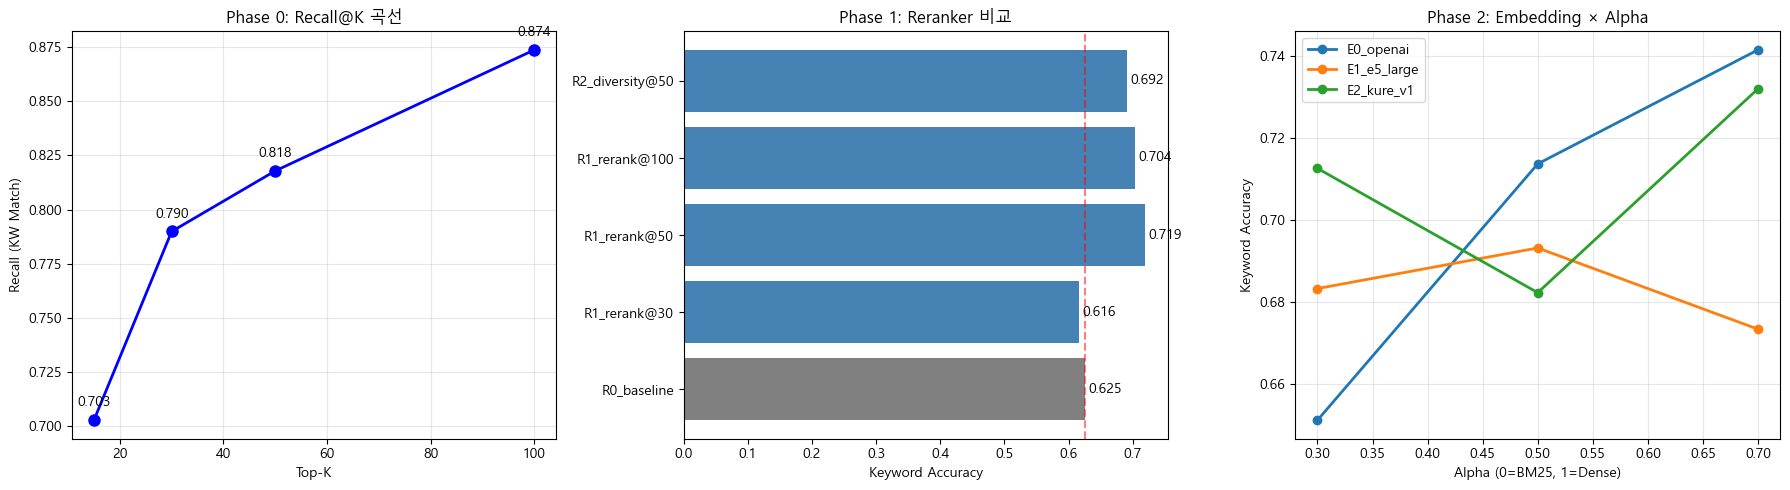

  Figure saved: ../data/experiments/exp04v3_results.png


In [15]:
# ============================================================
# 시각화
# ============================================================
import json
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.family'] = 'Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] = False

OUT_FIG_PATH = '../data/experiments/exp04v3_results.png'
OUT_DIAG_PATH = '../data/experiments/exp04v3_diagnostic.json'
INTERMEDIATE_PATH = '../data/experiments/exp04v3_intermediate.json'

# --- 변수 복원 ---
K_VALUES = [15, 30, 50, 100]

with open(OUT_DIAG_PATH, 'r', encoding='utf-8') as f:
    diag = json.load(f)
recall_at_k = diag['recall_at_k']

if 'phase1_results' not in dir():
    phase1_results = [
        {'config': 'R0_baseline', 'pool_size': 15, 'rerank': False, 'diversity': False,
         'keyword_accuracy': 0.6254, 'context_recall': 0.6333, 'latency_sec': 328.5},
        {'config': 'R1_rerank@30', 'pool_size': 30, 'rerank': True, 'diversity': False,
         'keyword_accuracy': 0.6164, 'context_recall': 0.7476, 'latency_sec': 372.7},
        {'config': 'R1_rerank@50', 'pool_size': 50, 'rerank': True, 'diversity': False,
         'keyword_accuracy': 0.7194, 'context_recall': 0.9000, 'latency_sec': 428.1},
        {'config': 'R1_rerank@100', 'pool_size': 100, 'rerank': True, 'diversity': False,
         'keyword_accuracy': 0.7036, 'context_recall': 0.9333, 'latency_sec': 1249.7},
        {'config': 'R2_diversity@50', 'pool_size': 50, 'rerank': True, 'diversity': True,
         'keyword_accuracy': 0.6916, 'context_recall': 0.9000, 'latency_sec': 1160.6},
    ]
    print('[복원] phase1_results')

if 'phase2_results' not in dir():
    with open(INTERMEDIATE_PATH, 'r', encoding='utf-8') as f:
        inter = json.load(f)
    phase2_results = inter['results'] if inter.get('phase') == 'phase2' else []
    print(f'[복원] phase2_results: {len(phase2_results)}개')

# ============================================================
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Recall@K 곡선 (Phase 0)
ax1 = axes[0]
k_means = [float(recall_at_k[str(k)]) for k in K_VALUES]
ax1.plot(K_VALUES, k_means, 'bo-', linewidth=2, markersize=8)
ax1.set_xlabel('Top-K')
ax1.set_ylabel('Recall (KW Match)')
ax1.set_title('Phase 0: Recall@K 곡선')
ax1.grid(True, alpha=0.3)
for k, m in zip(K_VALUES, k_means):
    ax1.annotate(f'{m:.3f}', (k, m), textcoords='offset points', xytext=(0, 10), ha='center')

# 2. Phase 1 Reranker 비교
ax2 = axes[1]
p1_names = [r['config'] for r in phase1_results]
p1_kw = [r['keyword_accuracy'] for r in phase1_results]
colors = ['gray' if not r['rerank'] else 'steelblue' for r in phase1_results]
bars = ax2.barh(p1_names, p1_kw, color=colors)
ax2.set_xlabel('Keyword Accuracy')
ax2.set_title('Phase 1: Reranker 비교')
ax2.axvline(x=p1_kw[0], color='red', linestyle='--', alpha=0.5, label='baseline')
for bar, val in zip(bars, p1_kw):
    ax2.text(val + 0.005, bar.get_y() + bar.get_height()/2, f'{val:.3f}', va='center')

# 3. Phase 2 Embedding × Alpha 비교
ax3 = axes[2]
if phase2_results:
    embeddings = sorted(set(r['embedding'] for r in phase2_results))
    alphas = sorted(set(r['alpha'] for r in phase2_results))
    color_map = {'E0_openai': '#1f77b4', 'E1_e5_large': '#ff7f0e', 'E2_kure_v1': '#2ca02c'}
    for emb in embeddings:
        emb_results = [r for r in phase2_results if r['embedding'] == emb]
        emb_results.sort(key=lambda x: x['alpha'])
        ax3.plot([r['alpha'] for r in emb_results],
                 [r['keyword_accuracy'] for r in emb_results],
                 'o-', label=emb, color=color_map.get(emb, 'gray'),
                 linewidth=2, markersize=6)
    ax3.set_xlabel('Alpha (0=BM25, 1=Dense)')
    ax3.set_ylabel('Keyword Accuracy')
    ax3.set_title('Phase 2: Embedding × Alpha')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
else:
    ax3.text(0.5, 0.5, 'Phase 2 미실행', ha='center', va='center', transform=ax3.transAxes)

plt.tight_layout()
plt.savefig(OUT_FIG_PATH, dpi=150, bbox_inches='tight')
plt.show()
print(f'  Figure saved: {OUT_FIG_PATH}')


## 결론

### 핵심 발견: 병목은 "파싱/인덱싱"이 아니라 "후보 압축(랭킹)"이었다

- **Oracle Recall 0.917** → 정답 근거는 인덱스에 거의 다 존재. 파싱/인덱싱은 주 병목이 아님
- **@50에는 있는데 @15에서 떨어짐 (갭 0.115)** → 후보 압축(랭킹) 문제가 실제 병목
- **Cross-encoder reranker가 이 병목을 크게 해결**: KW_Acc +0.094, CR 0.633 → **0.900**

### Phase별 결과 요약

| Phase | 핵심 결론 | 영향도 |
|-------|----------|--------|
| **Phase 1 (Reranker)** | bge-reranker-v2-m3, pool=50이 sweet spot. Diversity는 역효과 | **최대** (+0.094 KW_Acc) |
| **Phase 2 (Embedding)** | 모델 간 차이 미미(max 0.048). α=0.7(Dense 가중)이 일관되게 우수 | 중간 (α 튜닝 +0.022) |
| **Phase 3 (BM25)** | 3-stage 기여도 측정: Reranker 기여가 Dense의 3.4배 | 확인용 (토크나이저 비교 미완) |

> **"임베딩이 병목이 아니다"는 조건부로 유효**: reranker가 강해지면 embedding 차이가 가려질 수 있다는 점 유의.
> 현 시스템에서는 후보 생성 단계에서 dense 신호가 더 유효하고, 최종 성능을 좌우하는 건 reranker.

### 일관되게 실패하는 5개 질문 — 다음 실험의 핵심 대상

모든 reranker 설정에서 동일한 5개 질문이 recall 실패. 이는 다음 분기로 분류 가능:

1. **Oracle에 있으나 @50 후보에 없음** → retrieval 단계(쿼리 표현/토큰화) 문제
2. **@50에 있으나 rerank 후 @15에서 탈락** → reranker 판단 실패 (짧은 문맥/표 형태/특수기호)
3. **@15에 있으나 KW_Acc 실패** → 정답 정규화/평가 매칭 문제 (숫자·퍼센트·연차·표현 차이)

→ 5개 질문에 대해 **(a) Oracle 위치, (b) @50 포함 여부, (c) rerank 점수, (d) 정답 문자열 형태**를 정리하면 개선 방향이 즉시 결정됨.

### 표 질문 약점 (Recall@15=0.524) 개선 전략

EXP04-v2의 교훈: "표를 더 넣자"가 아니라 **"필요할 때만 강하게 쓰는 라우팅/표현"**이 핵심.

- **(A) 표 질문 라우팅**: 숫자/비율/연도/배점/금액 등 신호 감지 시 표 인덱스 우선 → 표 인덱스의 상시 경쟁 오염 방지
- **(B) 표 표현 2트랙 (라우팅 시에만)**: 표 원본(Markdown) + 행 선형화 텍스트를 후보로 올리고 reranker에 위임
- **(C) 표 답변은 "추출" 프롬프트로**: LLM 요약보다 정확한 값 추출이 중요. "(열=연도, 행=지급비율)을 찾아 답하라" 형태

### BM25 토크나이저 — 기술부채로 빠르게 종료

공백 split BM25는 한국어에서 조사/복합명사/기관명/약어 처리에 손해. 성능 영향이 작게 보였으나:
- kiwipiepy 1개만 붙여 "표/기관명/조항/제출서류" 키워드형 질의 subset에서 BM25 단독 Recall@K 확인
- 유의미하면 확장, 아니면 종료 (1~2일 내 결론)

### KURE-v1 — "전체 적용"이 아닌 "표 질문 전용" 부분 적용 검토

CR 0.967은 의미 있는 수치. 로컬 GPU 제약 하에서:
- 전체 트래픽이 아닌 **표 질문 라우팅이 켜진 경우에만 KURE로 dense retrieval** → 비용/지연 통제 + 약점 보강

---

### 다음 단계 로드맵

| 순서 | 작업 | 우선순위 |
|------|------|---------|
| 1 | **프로덕션 반영**: reranker(m3, pool=50) + α=0.7 고정 | 즉시 |
| 2 | **5개 실패 질문 포렌식**: Oracle/후보/rerank/매칭 분기 분석 | 높음 |
| 3 | **표 질문 전용 개선**: 라우팅 + 표현 2트랙 + 추출 프롬프트 | 높음 |
| 4 | **BM25 토크나이저 실험 종료**: kiwipiepy 1개만 빠르게 검증 | 중간 |
| 5 | **표 질문 한정 KURE 적용**: CR 극대화 실험 | 선택 |

**EXP04-v3 최종 성과**: KW_Acc 0.625 → **0.741**, CR 0.633 → **0.900**